In [1]:
import numpy as np
import pandas as pd
import os
import sys
from datetime import datetime

# Get the current working directory for Jupyter or interactive environments
current_dir = os.getcwd()

# Append project root to the system path for module imports
project_root = os.path.join(current_dir, '..')
sys.path.append(project_root)

from model.VotingModel import VotingModel
from model.EvalMetrics import EvalMetrics
from model.VotingRules import VotingRules

# Initialize simulation parameters
num_voters = 108
num_projects = 229
total_op_tokens = 8e6
num_rounds = 100
voter_type = 'r4_voting_matrix'
quorum = 17
simulation_description = 'r4 data simulations'

# Initialize the model
model = VotingModel(voter_type=voter_type, num_voters=num_voters, num_projects=num_projects, total_op_tokens=total_op_tokens)

# Initialize the evaluation metrics
model.step()
eval_metrics = EvalMetrics(model)

# Define the output directory with relative paths
output_dir = os.path.join(current_dir, '..', 'data', 'simulation_results', f'{simulation_description}')

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Compile and save fund allocations
allocation_df = model.compile_fund_allocations()
allocation_df.to_csv(os.path.join(output_dir, 'allocation_df.csv'), index=False)

# Save parameters to a text file
parameters = {
    "num_voters": num_voters,
    "num_projects": num_projects,
    "total_op_tokens": total_op_tokens,
    "num_rounds": num_rounds,
    "voter_type": voter_type,
    "quorum": quorum,
    "simulation_description": simulation_description
}

# Write the parameters to a txt file
param_file_path = os.path.join(output_dir, 'simulation_parameters.txt')
with open(param_file_path, 'w') as f:
    for key, value in parameters.items():
        f.write(f'{key}: {value}\n')

# Display the DataFrame
allocation_df


/Users/idrees/Code/govxs/metrics_evaluations/../agents/VoterAgent.py:10: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


,majoritarian_moving_phantoms,r1_quadratic,r2_mean,r3_median,r4_capped_median,Project
0,92238.395633,76575.516080,86995.770683,98133.434805,110433.896303,Project 1
1,2135.765118,15287.859753,5004.481466,1463.212384,1646.617639,Project 2
2,8538.125491,28331.620290,17872.006985,7981.812632,8982.286927,Project 3
3,231857.054621,124126.843364,227308.564998,244795.059159,275478.711536,Project 4
4,0.216227,1499.069715,138.595977,0.206422,0.000000,Project 5
...,...,...,...,...,...,...
225,12739.705933,29301.184008,15435.461554,12858.413726,14470.141913,Project 226
226,8080.390812,21399.732735,7771.674562,7349.672235,8239.876508,Project 227
227,2791.412912,12641.940075,2877.672847,2335.550372,2628.298174,Project 228
228,13745.451337,28338.878228,12915.757644,12790.213899,14393.393630,Project 229


# Evaluate Egalitarian Score


The **egalitarian score** metric measures how well the allocation of funds or resources is distributed with a focus on minimizing the worst-case dissatisfaction for any individual voter. In the context of your simulation, the egalitarian score is calculated by determining the maximum distance between the allocated outcome and each voter's preference, focusing on the most dissatisfied voter.

### Implementation Breakdown for Egalitarian Score

The function `calculate_egalitarian_score` evaluates this by computing the L1 norm (Manhattan distance) between the allocation (result of the voting rule) and the voting preferences for each voter. The **L1 distance** measures how far the allocation is from the voter's preference for each project. The largest of these distances (the worst-case dissatisfaction) is considered the **egalitarian score**.

#### Steps:
1. **Input Parameters**:
   - `allocation`: The result of the voting rule, i.e., how the resources are distributed across projects.
   - `voting_matrix`: The original voting preferences of each voter, where each row represents a voter, and each column represents a project.

2. **Distance Calculation**:
   - For each voter, the L1 norm (sum of absolute differences) is computed between the voter's preference and the allocation. This distance gives a measure of how far the allocation is from the voter's ideal distribution.
   - The goal is to capture the **maximum** of these distances, which represents the worst-case dissatisfaction.

3. **Return Value**:
   - The function returns the highest L1 distance, i.e., the worst-case dissatisfaction, which represents the egalitarian score for the allocation under the given voting rule.

Here’s a step-by-step explanation of how your code implements this:

```python
def calculate_egalitarian_score(self, allocation, voting_matrix):
    # Calculate the L1 distance between the allocation and each voter's preference
    distances = np.linalg.norm(voting_matrix - allocation, ord=1, axis=1)
    
    # Return the maximum of these distances, which represents the most dissatisfied voter
    return np.max(distances)
```

### Example Walkthrough:

1. **Voting Preferences (Voting Matrix)**:
   - Suppose there are 3 voters and 3 projects. The voting matrix might look like this:
     ```
     Voter 1: [5, 3, 2]
     Voter 2: [2, 6, 2]
     Voter 3: [1, 1, 8]
     ```
     This means that voter 1 allocated 5 tokens to project 1, 3 tokens to project 2, and 2 tokens to project 3, and so on for the other voters.

2. **Outcome (Allocation)**:
   - Let's assume that the outcome of the voting rule is:
     ```
     Allocation: [3, 5, 4]
     ```

3. **Calculating Distances**:
   - For each voter, the L1 distance between their voting preference and the allocation is computed:
     - Voter 1: `|5-3| + |3-5| + |2-4| = 2 + 2 + 2 = 6`
     - Voter 2: `|2-3| + |6-5| + |2-4| = 1 + 1 + 2 = 4`
     - Voter 3: `|1-3| + |1-5| + |8-4| = 2 + 4 + 4 = 10`

4. **Egalitarian Score**:
   - The maximum distance (worst-case dissatisfaction) is `10`, which corresponds to Voter 3. Thus, the **egalitarian score** for this allocation is 10.

### Function to Evaluate Egalitarian Score Across Multiple Rounds

The `evaluate_egalitarian_score` function evaluates the egalitarian score for multiple rounds, each time simulating new voter preferences and allocations:

```python
def evaluate_egalitarian_score(self, num_rounds=10):
    results = {'round': list(range(1, num_rounds + 1))}
    
    # Initialize result storage for each voting rule
    for voting_rule in self.model.voting_rules.keys():
        results[f'{voting_rule}_egalitarian_score'] = []
    
    # Loop over multiple rounds
    for round_num in range(num_rounds):
        self.model.step()  # Simulate the next round of voting
        
        for voting_rule in self.model.voting_rules.keys():
            allocation = self.model.allocate_funds(voting_rule)  # Get the allocation for this voting rule
            egalitarian_score = self.calculate_egalitarian_score(allocation, self.model.voting_matrix)  # Calculate the egalitarian score
            
            # Store the result
            results[f'{voting_rule}_egalitarian_score'].append(egalitarian_score)
    
    # Convert results to a DataFrame for easy analysis
    return pd.DataFrame(results)
```

#### Steps in `evaluate_egalitarian_score`:
1. Simulate multiple rounds of voting using the `step()` method.
2. For each round, apply different voting rules and calculate the resulting allocation.
3. Use the `calculate_egalitarian_score` function to measure the worst-case dissatisfaction for each allocation.
4. Store the results in a DataFrame for easy analysis and reporting.

### Summary:
- The **egalitarian score** is a metric that evaluates how equitable an allocation is by measuring the worst dissatisfaction among all voters.
- The implementation involves calculating the L1 distance between the allocation and each voter's preference, and the maximum distance is considered the egalitarian score.
- The `evaluate_egalitarian_score` function applies this metric over multiple rounds, providing a robust evaluation of different voting rules.

In [2]:
egalitarian_results=eval_metrics.evaluate_egalitarian_score(num_rounds)
egalitarian_results.to_csv(os.path.join(output_dir, 'egalitarian_results.csv'), index=False)
egalitarian_results

,round,majoritarian_moving_phantoms_egalitarian_score,r1_quadratic_egalitarian_score,r2_mean_egalitarian_score,r3_median_egalitarian_score,r4_capped_median_egalitarian_score
0,1,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
1,2,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
2,3,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
3,4,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
4,5,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
...,...,...,...,...,...,...
95,96,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
96,97,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
97,98,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
98,99,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06


In [3]:
egalitarian_results.describe()

,round,majoritarian_moving_phantoms_egalitarian_score,r1_quadratic_egalitarian_score,r2_mean_egalitarian_score,r3_median_egalitarian_score,r4_capped_median_egalitarian_score
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,50.500000,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
std,29.011492,9.360144e-10,0.000000e+00,9.360144e-10,1.872029e-09,9.360144e-10
min,1.000000,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
25%,25.750000,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
50%,50.500000,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
75%,75.250000,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06
max,100.000000,5.834888e+06,8.510754e+06,5.612542e+06,5.941370e+06,6.231274e+06


# Evaluate Gini Index


The **Gini index** is a measure of inequality that is used to evaluate how unevenly resources (or votes in your case) are distributed among projects or individuals. A Gini index of 0 represents perfect equality, where every project or voter has the same allocation, while a Gini index of 1 represents maximal inequality, where one project or voter holds all the resources.

In your context, the Gini index can be applied in two ways:
1. **Gini index of agents (voters)**: Measures the inequality among the utilities of voters, based on the L1 distances between the voters’ preferences and the actual allocation of resources.
2. **Gini index of projects**: Measures the inequality in the allocation of resources among the different projects.

### Implementation of the Gini Index for Projects

The **Gini index for projects** evaluates how resources (tokens) are allocated across different projects. If most of the tokens are allocated to a few projects, the Gini index will be high, indicating inequality.

#### Steps in `calculate_gini_index`:
1. **Sort the Allocation**: First, sort the allocation of tokens across projects.
2. **Calculate the Cumulative Allocation**: Compute the cumulative sum of the sorted allocations to generate the Lorenz curve.
3. **Compute the Gini Index**: The Gini index is derived using a formula based on the Lorenz curve, which measures the area between the line of equality (perfect distribution) and the actual distribution.

Here’s the function you implemented for calculating the Gini index:

```python
def calculate_gini_index(self, allocation):
    # Number of projects (or voters depending on what you're calculating)
    m = len(allocation)
    
    # Handle case where no allocation is given
    if m == 0:
        return 0
    
    # Step 1: Sort the allocation in ascending order
    allocation_sorted = np.sort(allocation)
    
    # Step 2: Compute cumulative allocation (Lorenz curve)
    cumulative_allocation = np.cumsum(allocation_sorted)
    
    # Step 3: Compute the Gini index using the formula
    numerator = 2 * np.sum((np.arange(1, m + 1) - 1) * allocation_sorted) - m * cumulative_allocation[-1]
    denominator = m * cumulative_allocation[-1]
    
    return numerator / denominator
```

### Breakdown of the Code:
1. **Sort the Allocation**:
   - The projects are sorted based on the allocated funds. This is important because the Gini index depends on the Lorenz curve, which is based on a cumulative distribution of the sorted values.
   
2. **Cumulative Allocation**:
   - The cumulative sum of the sorted allocation is computed. This cumulative sum is the Lorenz curve, which graphically represents the distribution of the allocation.
   
3. **Gini Index Calculation**:
   - The Gini index is computed using a formula based on the cumulative distribution. The formula:
     \[
     \text{Gini Index} = \frac{2 \sum_{i=1}^{m} (i - 1) a_i - m a_{\text{total}}}{m a_{\text{total}}}
     \]
     where \( a_i \) is the sorted allocation, \( m \) is the number of projects, and \( a_{\text{total}} \) is the total allocated tokens.

4. **Return Value**:
   - The function returns the Gini index, which measures the inequality in the allocation.

### Example Walkthrough:

1. **Allocations Across Projects**:
   - Suppose we have 5 projects and their allocated tokens are as follows:
     ```
     Project 1: 50 tokens
     Project 2: 30 tokens
     Project 3: 10 tokens
     Project 4: 5 tokens
     Project 5: 5 tokens
     ```

2. **Sorting the Allocations**:
   - Sorted allocations:
     ```
     [5, 5, 10, 30, 50]
     ```

3. **Cumulative Allocation**:
   - Cumulative sums:
     ```
     [5, 10, 20, 50, 100]
     ```

4. **Gini Index Calculation**:
   - The numerator is calculated as:
     \[
     2 \times (0 \times 5 + 1 \times 5 + 2 \times 10 + 3 \times 30 + 4 \times 50) - 5 \times 100 = 2 \times (0 + 5 + 20 + 90 + 200) - 500 = 630 - 500 = 130
     \]
   - The denominator is:
     \[
     5 \times 100 = 500
     \]
   - Therefore, the Gini index is:
     \[
     \frac{130}{500} = 0.26
     \]

### Evaluating the Gini Index Across Multiple Rounds

You’ve implemented a function to evaluate the Gini index for different voting rules across multiple rounds. The goal is to observe how the Gini index changes as the voting process is simulated, reflecting the equality (or inequality) in project allocations over time.

```python
def evaluate_gini_index(self, num_rounds=10):
    # Initialize a results dictionary to store the Gini index for each round
    results = {'round': list(range(1, num_rounds + 1))}
    
    # For each voting rule, create a new column in the results dictionary to track Gini index
    cumulative_allocations = {voting_rule: [] for voting_rule in self.model.voting_rules.keys()}
    for voting_rule in self.model.voting_rules.keys():
        results[f'{voting_rule}_gini_index'] = []
    
    # Simulate the voting process for a number of rounds
    for round_num in range(num_rounds):
        self.model.step()  # Simulate a new round of voting
        
        # For each voting rule, calculate the allocation and the corresponding Gini index
        for voting_rule in self.model.voting_rules.keys():
            allocation = self.model.allocate_funds(voting_rule)  # Get the allocation for the current voting rule
            
            # Calculate the Gini index for the current allocation
            gini_index = self.calculate_gini_index(allocation)
            
            # Store the Gini index in the results
            results[f'{voting_rule}_gini_index'].append(gini_index)
            
            # Store cumulative allocations for Lorenz curve analysis if needed
            sorted_cumulative_allocation = np.cumsum(np.sort(allocation)) / np.sum(allocation)
            cumulative_allocations[voting_rule].append(sorted_cumulative_allocation)

    # Convert the results into a DataFrame for easy visualization
    return pd.DataFrame(results), cumulative_allocations
```

#### Steps in `evaluate_gini_index`:
1. **Initialize Results**:
   - Create a dictionary to store the Gini index for each voting rule across multiple rounds.

2. **Simulate Voting**:
   - For each round, simulate the voting process using the `step()` method, which advances the model to the next state.
   
3. **Calculate Gini Index for Each Voting Rule**:
   - For each voting rule, calculate the allocation of resources and then compute the Gini index using the `calculate_gini_index` function.
   
4. **Store Cumulative Allocations**:
   - The cumulative allocation (used for Lorenz curve analysis) is also stored for each voting rule.
   
5. **Return Results**:
   - The results are returned as a DataFrame, which can be used for further analysis or visualization of the Gini index trends over time.

### Summary:
- The **Gini index** measures the inequality of the allocation across projects or voters. A high Gini index indicates more inequality in the allocation.
- The `calculate_gini_index` function computes this measure based on the Lorenz curve.
- The `evaluate_gini_index` function allows you to track how the Gini index evolves across multiple rounds and under different voting rules, giving insight into the fairness and equality of the resource allocation process.

In [4]:
gini_results,allocations = eval_metrics.evaluate_gini_index(num_rounds)
gini_results.to_csv(os.path.join(output_dir, 'gini_results.csv'), index=False)
print("Gini Index Results:")
gini_results.head(100)

Gini Index Results:


,round,majoritarian_moving_phantoms_gini_index,r1_quadratic_gini_index,r2_mean_gini_index,r3_median_gini_index,r4_capped_median_gini_index
0,1,0.728502,0.420667,0.710133,0.742392,0.707663
1,2,0.728502,0.420667,0.710133,0.742392,0.707663
2,3,0.728502,0.420667,0.710133,0.742392,0.707663
3,4,0.728502,0.420667,0.710133,0.742392,0.707663
4,5,0.728502,0.420667,0.710133,0.742392,0.707663
...,...,...,...,...,...,...
95,96,0.728502,0.420667,0.710133,0.742392,0.707663
96,97,0.728502,0.420667,0.710133,0.742392,0.707663
97,98,0.728502,0.420667,0.710133,0.742392,0.707663
98,99,0.728502,0.420667,0.710133,0.742392,0.707663


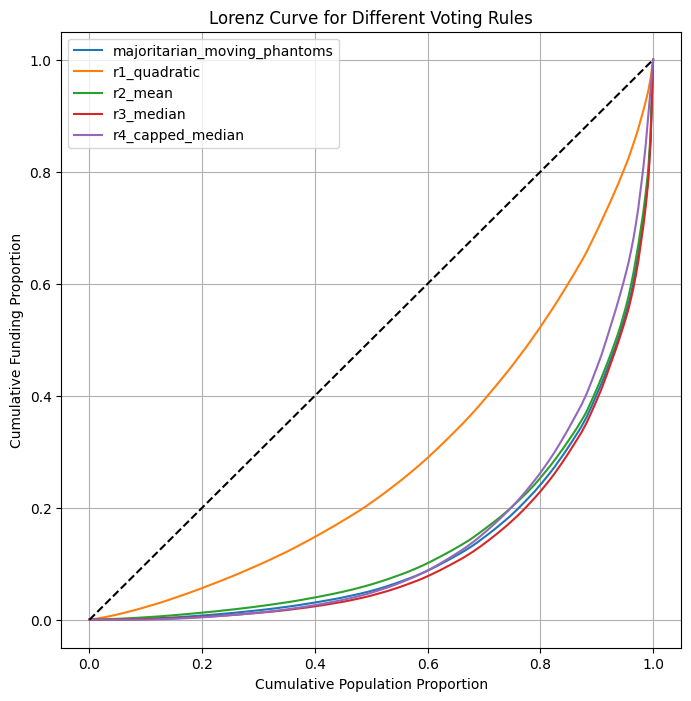

In [5]:
import matplotlib.pyplot as plt
def plot_lorenz_curve(averaged_cumulative_allocations):
        plt.figure(figsize=(8, 8))
        
        for voting_rule, lorenz_values in averaged_cumulative_allocations.items():
            # Lorenz curve starts at (0,0)
            plt.plot(np.linspace(0, 1, len(lorenz_values)), lorenz_values, label=voting_rule)
        
        # Line of equality
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
        
        plt.xlabel('Cumulative Population Proportion')
        plt.ylabel('Cumulative Funding Proportion')
        plt.title('Lorenz Curve for Different Voting Rules')
        plt.legend()
        plt.grid(True)
        plt.show()
plot_lorenz_curve(allocations)

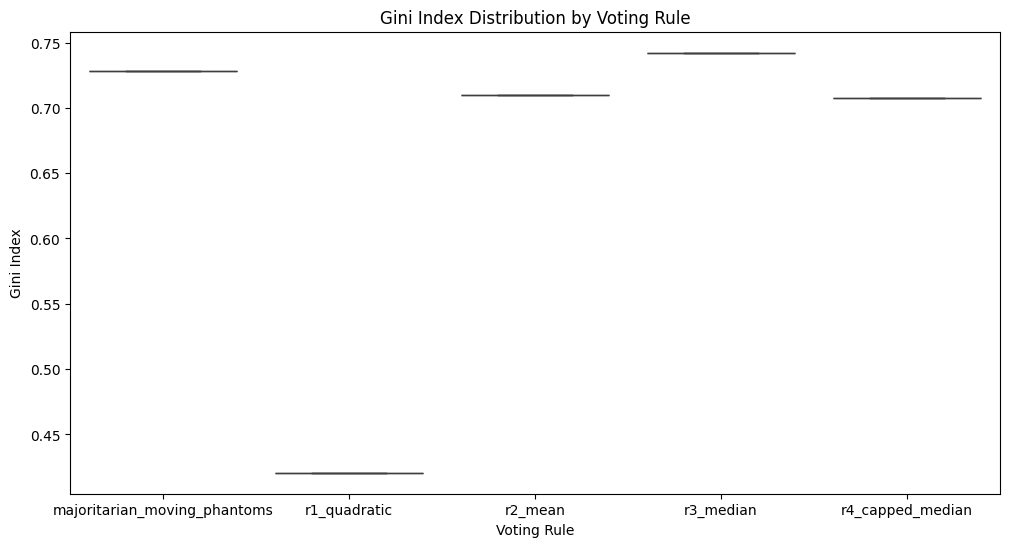

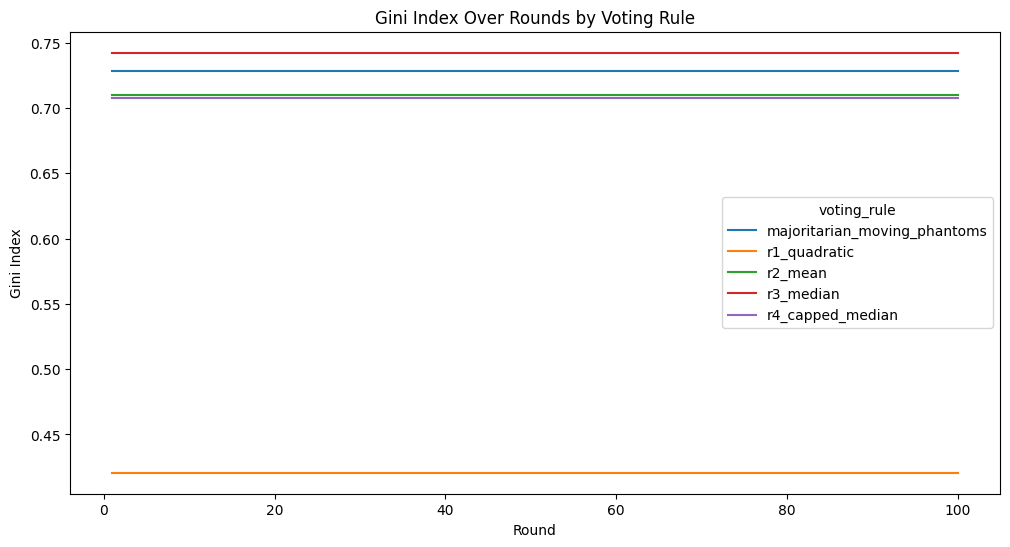

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for box plot
gini_results_long = gini_results.melt(id_vars=['round'], var_name='voting_rule', value_name='gini_index')
gini_results_long['voting_rule'] = gini_results_long['voting_rule'].str.replace('_gini_index', '')

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='voting_rule', y='gini_index', data=gini_results_long)
plt.title('Gini Index Distribution by Voting Rule')
plt.xlabel('Voting Rule')
plt.ylabel('Gini Index')
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='round', y='gini_index', hue='voting_rule', data=gini_results_long)
plt.title('Gini Index Over Rounds by Voting Rule')
plt.xlabel('Round')
plt.ylabel('Gini Index')
plt.show()


# Evaluate Alignment with Ground Truth



The **alignment with the ground truth** metric evaluates how well the voting outcome aligns with a predefined "ground truth" allocation, assuming such a ground truth exists. This metric helps assess how close the outcome produced by a voting rule is to the ideal or expected allocation.

In your simulation, the **alignment with the ground truth** metric compares the allocation generated by each voting rule to a ground truth allocation. The comparison is quantified using the **Hamming distance**, which measures the number of positions where the allocation differs from the ground truth. The goal is to minimize this distance, indicating a closer alignment between the voting outcome and the ground truth.

### Implementation of the Alignment Metric in the `EvalMetrics` Class

#### Key Steps in Implementing the Metric

1. **Generate Ground Truth**: 
   - First, you generate a ground truth allocation, which serves as the baseline or ideal allocation to which the voting outcomes will be compared.

2. **Calculate Hamming Distance**: 
   - The **Hamming distance** measures how many positions differ between two vectors. In this case, it compares the top-k projects in the voting rule's outcome with the top-k projects in the ground truth.

3. **Evaluate Alignment**:
   - The function runs for multiple rounds, calculates the voting outcome for each round and compares it with the ground truth. For each voting rule, the distance between the ground truth and the outcome is calculated and stored.

### Step 1: Generate Ground Truth

The `generate_ground_truth` function generates a random allocation across projects based on a multinomial distribution. This ground truth represents the ideal allocation of resources (or tokens) that serves as the baseline for comparison.

```python
def generate_ground_truth(self, num_projects):
    # Generate ground truth allocation using a multinomial distribution
    ground_truth = np.random.multinomial(self.model.total_op_tokens, [1.0/self.model.num_projects] * self.model.num_projects)
    return ground_truth
```

#### Explanation:
- **Multinomial Distribution**: 
   - This function generates a random ground truth allocation where the total number of tokens (votes) is distributed across projects according to a uniform probability distribution. This models a scenario where each project has an equal probability of receiving votes, and the resulting allocation serves as the "true" distribution of tokens.

### Step 2: Calculate Hamming Distance

The Hamming distance measures how many elements in two sets differ. In this case, it compares the top-k projects in the voting rule's outcome with the top-k projects in the ground truth.

```python
def calculate_hamming_distance(self, x, x_star, top_k):
    # Extract the top-k projects from the two allocations (x and ground truth x_star)
    x_top_k = np.argsort(-x)[:top_k]
    x_star_top_k = np.argsort(-x_star)[:top_k]
    
    # Calculate Hamming distance by counting non-overlapping projects in the top-k lists
    return np.sum(np.isin(x_top_k, x_star_top_k, invert=True))
```

#### Explanation:
- **Sorting the Projects**:
   - The `np.argsort(-x)` sorts the projects in descending order of their allocation in both the voting outcome `x` and the ground truth `x_star`. This gives us the indices of the top-k projects for comparison.
   
- **Comparing Top-k Projects**:
   - The `np.isin(x_top_k, x_star_top_k, invert=True)` checks which projects in the top-k of `x` (the voting outcome) are not in the top-k of `x_star` (the ground truth). The Hamming distance is simply the number of mismatches between the two top-k sets.

### Step 3: Evaluate Alignment

The `evaluate_alignment` function evaluates the alignment of the voting outcome with the ground truth across multiple rounds of voting.

```python
def evaluate_alignment(self, num_rounds=10):
    # Generate ground truth for alignment evaluation
    ground_truth = self.generate_ground_truth(self.model.num_projects)
    top_k = 200  # Number of top projects to compare for Hamming distance 

    # Initialize a dictionary to store results
    results = {'round': list(range(1, num_rounds + 1))}
    for voting_rule in self.model.voting_rules.keys():
        results[f'{voting_rule}_l1_distance'] = []

    # Loop through multiple rounds
    for round_num in range(num_rounds):
        self.model.step()  # Simulate the next round of voting
        
        # For each voting rule, calculate the alignment with the ground truth
        for voting_rule in self.model.voting_rules.keys():
            # Get the allocation based on the current voting rule
            allocation = self.model.allocate_funds(voting_rule)
            
            # Normalize the allocation
            allocation_normalized = allocation / np.sum(allocation)
            
            # Calculate L1 distance (an optional variant you may use in conjunction with Hamming distance)
            l1_distance = self.calculate_l1_distance(allocation, ground_truth)
            
            # Store the alignment score (L1 distance in this case)
            results[f'{voting_rule}_l1_distance'].append(l1_distance)
    
    # Convert results to a DataFrame for easier analysis
    return pd.DataFrame(results)
```

#### Explanation:
- **Generate Ground Truth**:
   - A ground truth allocation is generated at the start, and it remains the same across all rounds. This ensures a consistent baseline for comparison.
   
- **Run the Voting Simulation**:
   - The `model.step()` function simulates the next round of voting, updating the vote profiles.

- **Calculate Alignment**:
   - For each voting rule, the allocation of funds is computed using the `allocate_funds` method. The allocation is normalized (divided by the sum of tokens) to make it comparable to the ground truth.
   - The alignment is measured using the **L1 distance** (or optionally Hamming distance). The L1 distance is another measure of similarity that calculates the absolute differences between two distributions.

- **Store Results**:
   - The alignment score (L1 distance) is stored for each voting rule across multiple rounds. At the end of the evaluation, the results are returned as a DataFrame for further analysis.

### Example Walkthrough:

1. **Ground Truth Allocation**:
   - Suppose there are 5 projects, and the ground truth allocation is:
     ```
     Ground Truth: [100, 50, 25, 15, 10]
     ```

2. **Voting Rule Outcome**:
   - The allocation generated by a particular voting rule might look like this:
     ```
     Voting Outcome: [90, 60, 20, 15, 15]
     ```

3. **Top-k Comparison**:
   - If `top_k = 3`, we compare the top 3 projects in both the ground truth and voting outcome.
     - Ground truth top 3: Projects 1, 2, and 3.
     - Voting outcome top 3: Projects 1, 2, and 4.
   - The Hamming distance would be 1, since project 3 in the ground truth is replaced by project 4 in the voting outcome.

4. **Repeat for Multiple Voting Rules**:
   - The process is repeated for each voting rule in each round, and the alignment with the ground truth is calculated and recorded.

### Summary:
- The **alignment with the ground truth** metric measures how close the voting rule’s outcome is to a predefined ideal allocation (the ground truth).
- The **Hamming distance** is used to compare the top-k projects between the voting outcome and the ground truth, indicating how many of the top projects are mismatched.
- The function `evaluate_alignment` runs multiple rounds of simulations, calculates the alignment for different voting rules, and stores the results for analysis.

This metric is useful for understanding how well a voting system approximates an expected or ideal allocation.

In [7]:
alignment_results = eval_metrics.evaluate_alignment(num_rounds)
alignment_results.to_csv(os.path.join(output_dir, 'alignment_results.csv'), index=False)
print("Alignment Results:")
alignment_results.head(100)

Alignment Results:


,round,majoritarian_moving_phantoms_l1_distance,r1_quadratic_l1_distance,r2_mean_l1_distance,r3_median_l1_distance,r4_capped_median_l1_distance
0,1,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
1,2,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
2,3,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
3,4,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
4,5,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
...,...,...,...,...,...,...
95,96,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
96,97,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
97,98,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06
98,99,9.010062e+06,5.018091e+06,8.802644e+06,9.200343e+06,8.678317e+06


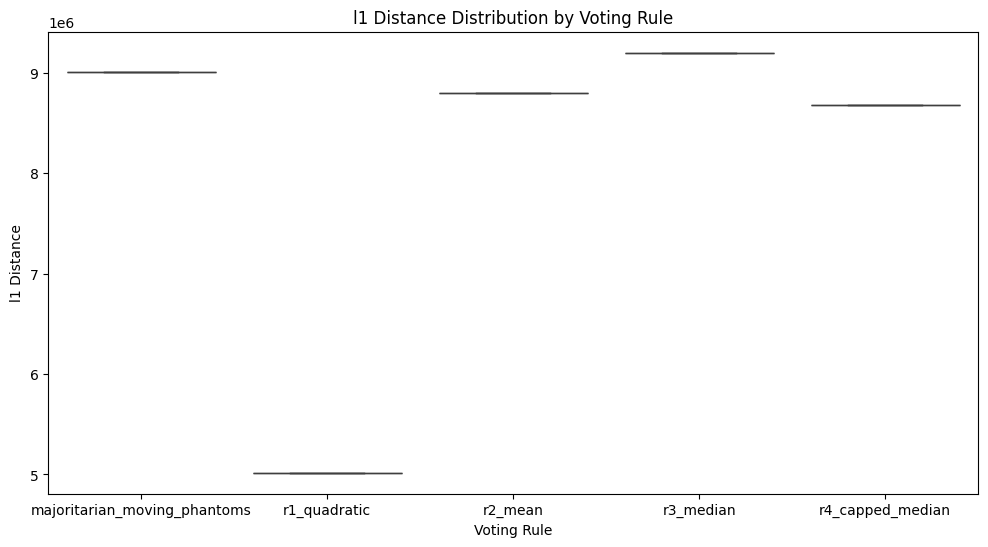

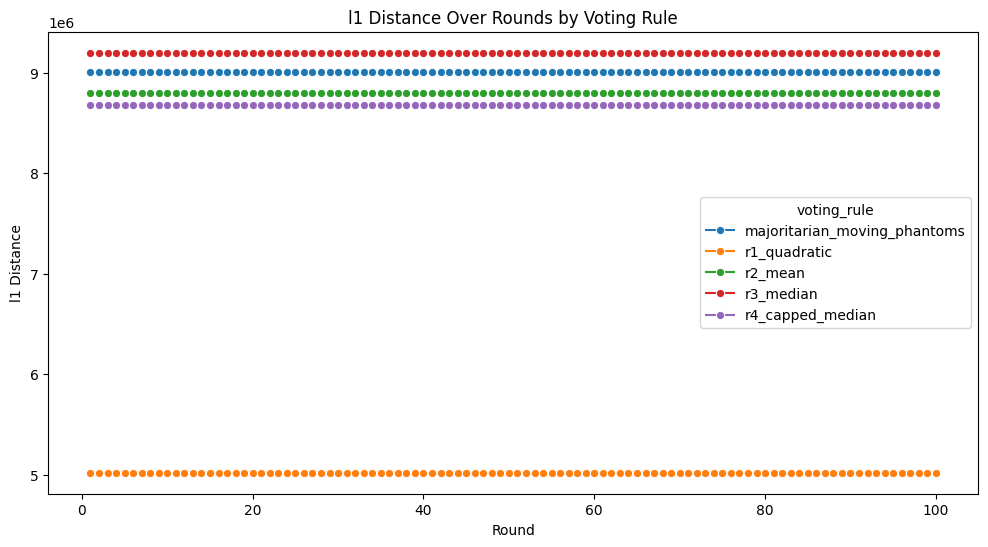

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
alignment_results_long = alignment_results.melt(id_vars=['round'], var_name='voting_rule', value_name='l1_distance')
alignment_results_long['voting_rule'] = alignment_results_long['voting_rule'].str.replace('_l1_distance', '')

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='voting_rule', y='l1_distance', data=alignment_results_long)
plt.title('l1 Distance Distribution by Voting Rule')
plt.xlabel('Voting Rule')
plt.ylabel('l1 Distance')
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='round', y='l1_distance', hue='voting_rule', data=alignment_results_long, marker='o')
plt.title('l1 Distance Over Rounds by Voting Rule')
plt.xlabel('Round')
plt.ylabel('l1 Distance')
plt.show()


In [9]:
def calculate_alignment_metrics(alignment_results):
    metrics = {
        "voting_rule": [],
        "mean_l1_distance": [],
        "std_l1_distance": [],
        "min_l1_distance": [],
        "max_l1_distance": []
    }
    
    for voting_rule in model.voting_rules.keys():
        l1_distances = alignment_results[f"{voting_rule}_l1_distance"]
        metrics["voting_rule"].append(voting_rule)
        metrics["mean_l1_distance"].append(np.mean(l1_distances))
        metrics["std_l1_distance"].append(np.std(l1_distances))
        metrics["min_l1_distance"].append(np.min(l1_distances))
        metrics["max_l1_distance"].append(np.max(l1_distances))
    
    return pd.DataFrame(metrics)

# Calculate metrics
alignment_metrics = calculate_alignment_metrics(alignment_results)

alignment_metrics


,voting_rule,mean_l1_distance,std_l1_distance,min_l1_distance,max_l1_distance
0,majoritarian_moving_phantoms,9.010062e+06,1.862645e-09,9.010062e+06,9.010062e+06
1,r1_quadratic,5.018091e+06,9.313226e-10,5.018091e+06,5.018091e+06
2,r2_mean,8.802644e+06,0.000000e+00,8.802644e+06,8.802644e+06
3,r3_median,9.200343e+06,1.862645e-09,9.200343e+06,9.200343e+06
4,r4_capped_median,8.678317e+06,1.862645e-09,8.678317e+06,8.678317e+06


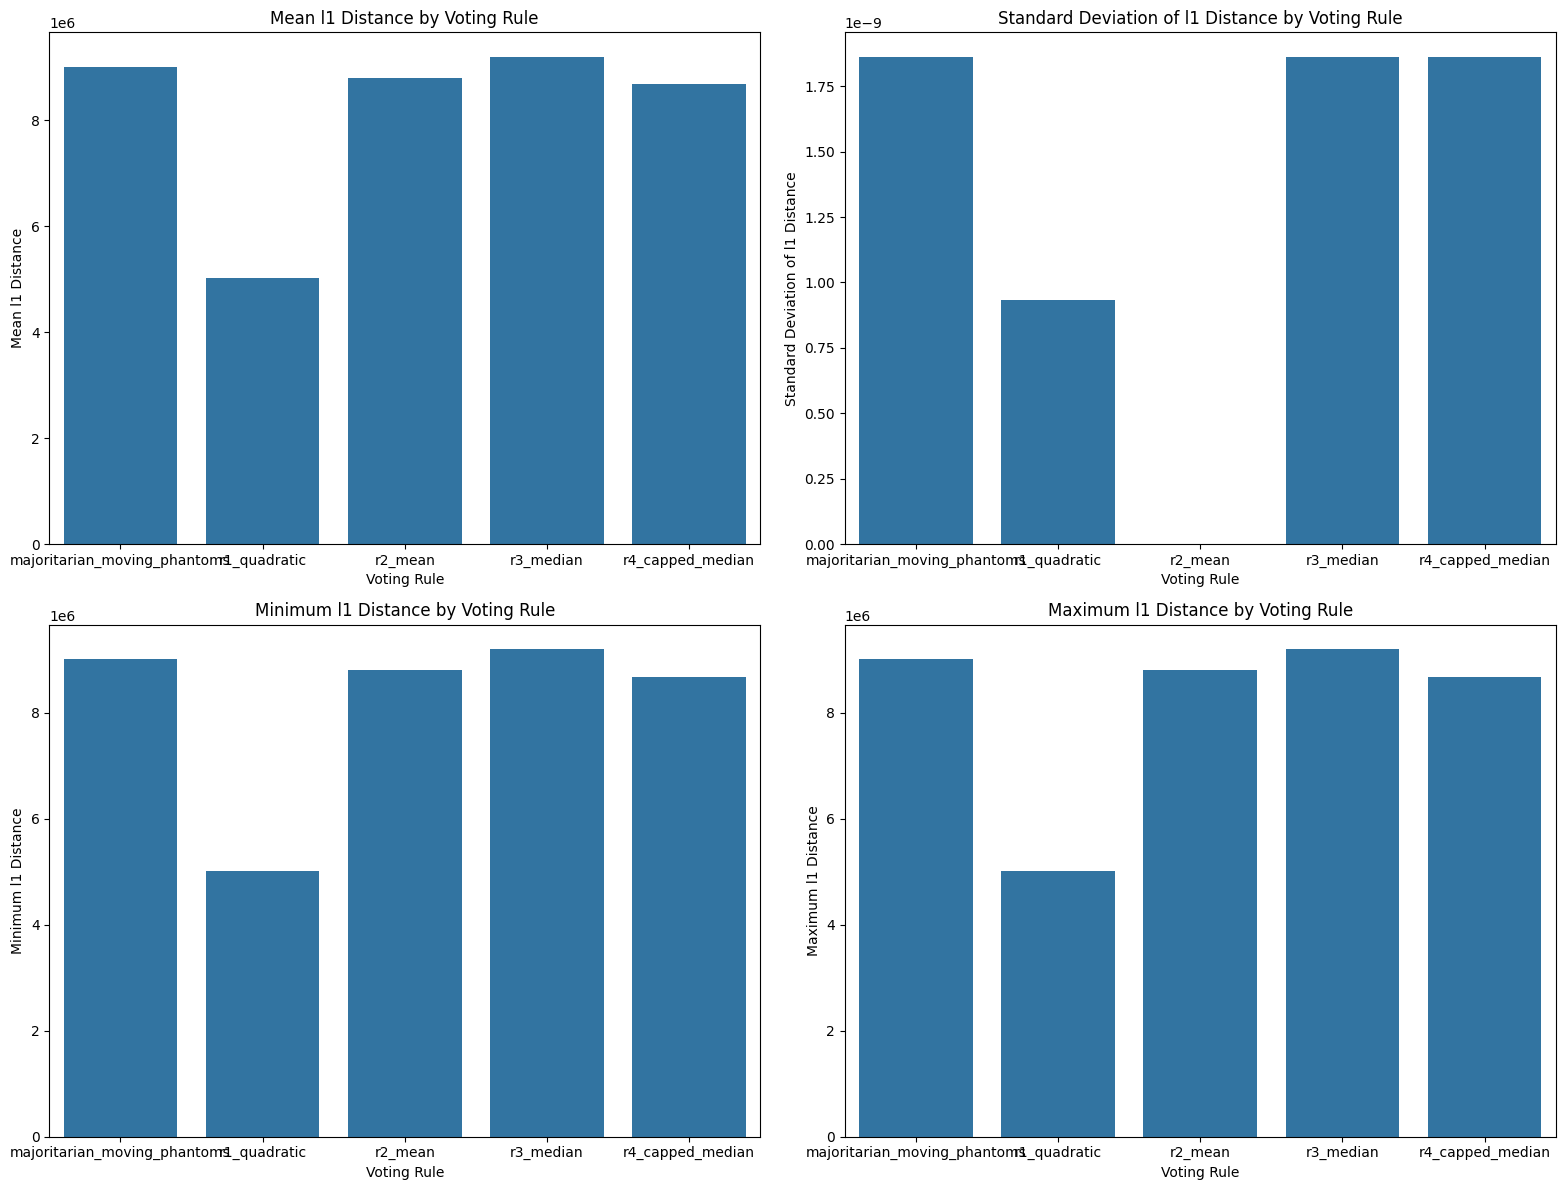

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mean l1 Distance
sns.barplot(x='voting_rule', y='mean_l1_distance', data=alignment_metrics, ax=axes[0, 0])
axes[0, 0].set_title('Mean l1 Distance by Voting Rule')
axes[0, 0].set_xlabel('Voting Rule')
axes[0, 0].set_ylabel('Mean l1 Distance')

# Standard Deviation of l1 Distance
sns.barplot(x='voting_rule', y='std_l1_distance', data=alignment_metrics, ax=axes[0, 1])
axes[0, 1].set_title('Standard Deviation of l1 Distance by Voting Rule')
axes[0, 1].set_xlabel('Voting Rule')
axes[0, 1].set_ylabel('Standard Deviation of l1 Distance')

# Minimum l1 Distance
sns.barplot(x='voting_rule', y='min_l1_distance', data=alignment_metrics, ax=axes[1, 0])
axes[1, 0].set_title('Minimum l1 Distance by Voting Rule')
axes[1, 0].set_xlabel('Voting Rule')
axes[1, 0].set_ylabel('Minimum l1 Distance')

# Maximum l1 Distance
sns.barplot(x='voting_rule', y='max_l1_distance', data=alignment_metrics, ax=axes[1, 1])
axes[1, 1].set_title('Maximum l1 Distance by Voting Rule')
axes[1, 1].set_xlabel('Voting Rule')
axes[1, 1].set_ylabel('Maximum l1 Distance')

plt.tight_layout()
plt.show()


# Evaluate Social Welfare



The **social welfare** metric measures the overall satisfaction of voters by assessing how close the final allocation of resources (as determined by a voting rule) is to the preferences of individual voters. In the context of your simulation, social welfare is computed as the **average L1 distance** (Manhattan distance) between the voting outcome (allocation) and each voter’s preferences. The goal is to minimize this distance, as a lower value indicates that the allocation is closer to voters' preferences, thus maximizing social welfare.

### Implementation of the Social Welfare Metric in the `EvalMetrics` Class

In the `EvalMetrics` class, the social welfare metric evaluates how well each voting rule's allocation satisfies the voters' preferences, averaged across all voters. The process involves comparing the final allocation to each voter's preferences and calculating the L1 distance between them. 

#### Key Steps in Implementing the Social Welfare Metric

1. **Calculate L1 Distance**: 
   - The L1 distance measures how far the allocation differs from a voter's preferences for each project.
   - For each voter, compute the sum of the absolute differences between the allocation and their preference.

2. **Average the L1 Distances**:
   - The average of the L1 distances across all voters gives an overall measure of the system's social welfare under a given voting rule.

3. **Evaluate Social Welfare**:
   - The function evaluates social welfare over multiple rounds and for different voting rules.

### Step 1: Calculate L1 Distance

The **L1 distance** function is used to measure how far the allocation (resulting from a voting rule) is from a voter’s preference. This is computed for each voter and used as the basis for calculating social welfare.

```python
def calculate_l1_distance(self, x, x_prime):
    """Calculate the L1 distance (Manhattan distance) between two vectors."""
    return np.sum(np.abs(x - x_prime))
```

#### Explanation:
- **L1 Distance**:
   - The L1 distance, or Manhattan distance, is the sum of the absolute differences between two vectors. In this case, `x` represents the allocation from the voting rule, and `x_prime` represents the preference of a particular voter.
   - The function returns the total L1 distance, which indicates how different the allocation is from the voter's ideal distribution of tokens.

### Step 2: Evaluate Social Welfare

The `evaluate_social_welfare` function evaluates social welfare across multiple rounds of voting. It calculates the average L1 distance between the allocation (as determined by each voting rule) and each voter's preferences, providing a measure of how well the voting system aligns with voter preferences overall.

```python
def evaluate_social_welfare(self, num_rounds=10):
    # Initialize results dictionary to store the social welfare values for each round and voting rule
    results = {'round': list(range(1, num_rounds + 1))}
    
    # Create a column in the results dictionary for each voting rule's social welfare
    for voting_rule in self.model.voting_rules.keys():
        results[f'{voting_rule}_social_welfare_avg_l1_distance'] = []

    # Loop over multiple rounds
    for round_num in range(num_rounds):
        self.model.step()  # Simulate the next round of voting
        
        # For each voting rule, calculate the social welfare
        for voting_rule in self.model.voting_rules.keys():
            # Get the allocation of funds based on the current voting rule
            outcome = self.model.allocate_funds(voting_rule)
            
            total_distance = 0  # Initialize total distance to accumulate for this round
            
            # Calculate the L1 distance between the outcome and each voter's preferences
            for i in range(self.model.num_voters):
                total_distance += self.calculate_l1_distance(outcome, self.model.voting_matrix[i])
            
            # Compute the average distance (social welfare) across all voters
            average_distance = total_distance / self.model.num_voters
            
            # Store the average L1 distance (social welfare) for this voting rule and round
            results[f'{voting_rule}_social_welfare_avg_l1_distance'].append(average_distance)

    # Convert the results into a DataFrame for easy analysis and visualization
    return pd.DataFrame(results)
```

#### Explanation:
- **Results Initialization**:
   - The `results` dictionary is initialized to store the average L1 distances (social welfare) for each round and each voting rule. For each voting rule, a new column is added to the results dictionary.
   
- **Loop Over Rounds**:
   - The function simulates multiple rounds of voting using `self.model.step()`, which advances the simulation by one step, updating the voting matrix (preferences of voters).

- **Calculate Social Welfare**:
   - For each voting rule, the allocation is computed using `self.model.allocate_funds(voting_rule)`, which generates the final distribution of tokens across projects based on the current voting rule.
   - The L1 distance between the allocation and each voter’s preferences is computed using the `calculate_l1_distance` function.
   - The total L1 distance is accumulated over all voters, and the average is taken to represent the overall social welfare for that voting rule in the current round.

- **Store Results**:
   - The average L1 distance (social welfare) for each voting rule is stored in the results dictionary.
   
- **Return Results**:
   - The results are returned as a DataFrame for easy analysis and visualization.

### Example Walkthrough:

1. **Voting Preferences**:
   - Suppose there are 3 voters and 3 projects, with the following voting preferences (voting matrix):
     ```
     Voter 1: [5, 3, 2]
     Voter 2: [2, 6, 2]
     Voter 3: [1, 1, 8]
     ```

2. **Outcome from a Voting Rule**:
   - The voting rule results in the following allocation:
     ```
     Allocation: [3, 5, 4]
     ```

3. **Calculate L1 Distances**:
   - For each voter, compute the L1 distance between their preferences and the allocation:
     - Voter 1: `|5-3| + |3-5| + |2-4| = 2 + 2 + 2 = 6`
     - Voter 2: `|2-3| + |6-5| + |2-4| = 1 + 1 + 2 = 4`
     - Voter 3: `|1-3| + |1-5| + |8-4| = 2 + 4 + 4 = 10`
     
4. **Calculate Average L1 Distance (Social Welfare)**:
   - The average L1 distance (social welfare) is:
     \[
     \frac{6 + 4 + 10}{3} = \frac{20}{3} \approx 6.67
     \]
   - This is the social welfare score for this round and voting rule.

5. **Repeat for Multiple Voting Rules**:
   - The process is repeated for each voting rule, and the average L1 distance (social welfare) is recorded for each rule.

### Summary:
- The **social welfare** metric evaluates how closely the voting outcome aligns with the preferences of individual voters.
- It is computed as the **average L1 distance** between the allocation produced by a voting rule and each voter’s preferences. A lower L1 distance indicates higher social welfare.
- The `evaluate_social_welfare` function runs multiple rounds of voting, computes the average social welfare for each voting rule, and returns the results in a DataFrame.
- This metric provides a measure of how well the voting system satisfies the preferences of the electorate as a whole.

In [11]:
social_welfare_results = eval_metrics.evaluate_social_welfare(num_rounds)
social_welfare_results.to_csv(os.path.join(output_dir, 'social_welfare_results.csv'), index=False)
print("Social Welfare Results:")
social_welfare_results.head(100)

Social Welfare Results:


,round,majoritarian_moving_phantoms_social_welfare_avg_l1_distance,r1_quadratic_social_welfare_avg_l1_distance,r2_mean_social_welfare_avg_l1_distance,r3_median_social_welfare_avg_l1_distance,r4_capped_median_social_welfare_avg_l1_distance
0,1,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
1,2,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
2,3,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
3,4,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
4,5,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
...,...,...,...,...,...,...
95,96,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
96,97,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
97,98,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06
98,99,3.025031e+06,5.420223e+06,3.062570e+06,3.043303e+06,3.631537e+06


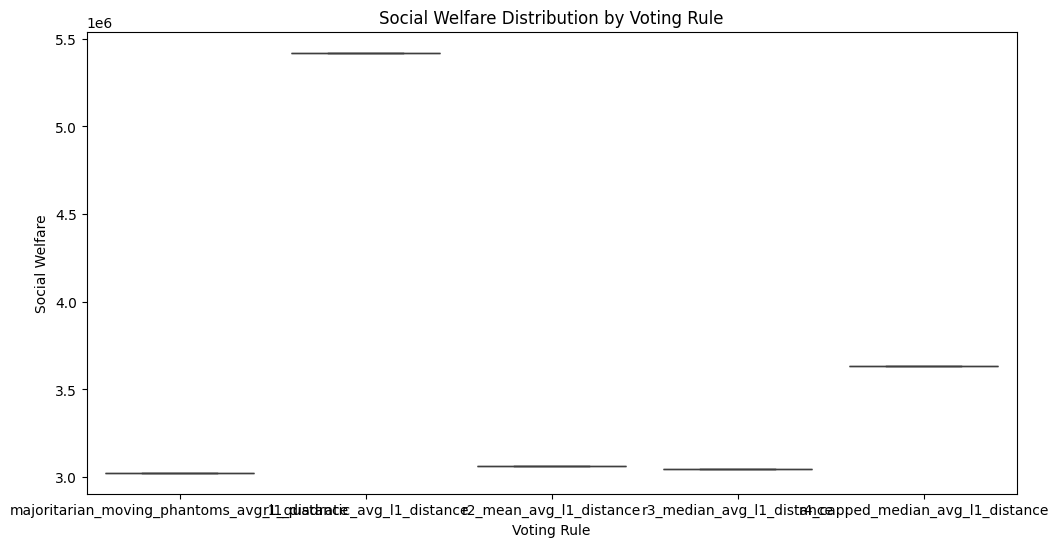

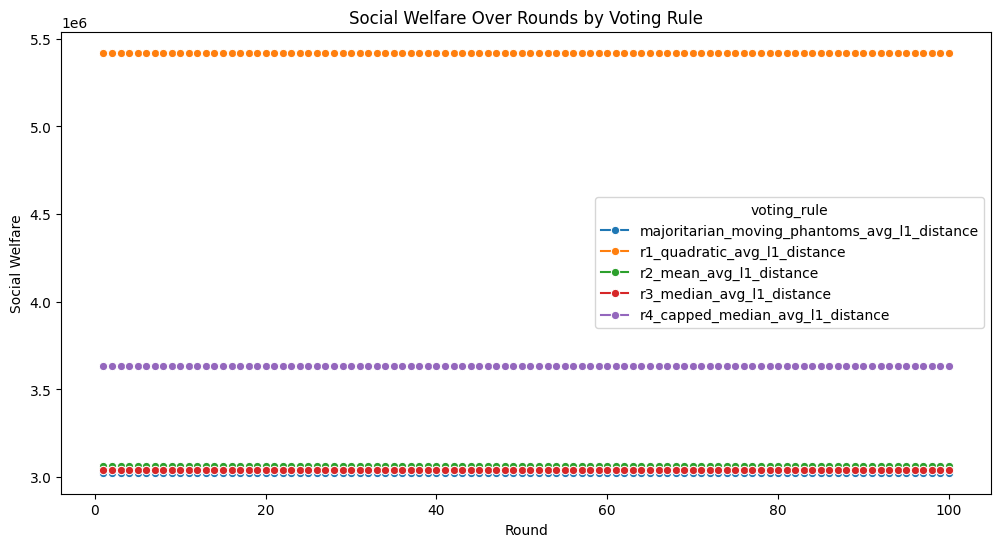

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
social_welfare_results_long = social_welfare_results.melt(id_vars=['round'], var_name='voting_rule', value_name='social_welfare')
social_welfare_results_long['voting_rule'] = social_welfare_results_long['voting_rule'].str.replace('_social_welfare', '')

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='voting_rule', y='social_welfare', data=social_welfare_results_long)
plt.title('Social Welfare Distribution by Voting Rule')
plt.xlabel('Voting Rule')
plt.ylabel('Social Welfare')
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='round', y='social_welfare', hue='voting_rule', data=social_welfare_results_long, marker='o')
plt.title('Social Welfare Over Rounds by Voting Rule')
plt.xlabel('Round')
plt.ylabel('Social Welfare')
plt.show()


In [13]:
abc

NameError: name 'abc' is not defined

# Evaluate Resistance to Control


The **resistance to control** metric evaluates how difficult it is for an external entity to influence or manipulate the outcome of a voting system by adding or removing voters. The goal is to measure the system’s ability to resist attempts at controlling the results, either by increasing or decreasing the allocation to a specific project.

In your `EvalMetrics` class, the **resistance to control** is implemented by simulating two scenarios:
1. **Voter addition**: The number of voters that need to be added to increase the funding for a target project by a desired percentage.
2. **Voter removal**: The number of voters that need to be removed to achieve the same increase in funding for a target project.

These metrics help in understanding how vulnerable the system is to manipulation and how much effort is required to shift the outcome in favor of a particular project.

### Implementation of the Resistance to Control Metric in the `EvalMetrics` Class

#### Key Steps in Implementing Resistance to Control:
1. **Simulate Voter Addition**:
   - Add new voters who cast their entire vote to the target project. Continue adding voters until the desired increase in funding for the target project is achieved.
   
2. **Simulate Voter Removal**:
   - Remove voters who are least favorable to the target project (those who give the fewest votes to the target project). Continue removing voters until the desired increase in funding is achieved.

3. **Evaluate Control**:
   - The function evaluates resistance to control over multiple rounds. For each round, it calculates the minimal number of voters that need to be added or removed to achieve a desired increase in funding for the target project.

### Step 1: Simulate Voter Addition

The `simulate_voter_addition` function simulates the process of adding new voters to increase the funding of a target project by a specified percentage. It adds voters until the target funding increase is achieved or until a limit on the number of additional voters is reached.

```python
def simulate_voter_addition(self, project, voting_rule, desired_increase):
    num_voters, num_projects = self.model.voting_matrix.shape
    original_allocation = self.model.allocate_funds(voting_rule)
    original_funds = original_allocation[project]
    target_funds = original_funds * (1 + desired_increase / 100)
    added_voters = 0

    max_additional_voters = num_voters * 0.5  # Limit to avoid infinite loop

    # Create a copy of the original voting matrix to work with
    potential_voting_matrix = self.model.voting_matrix.copy()

    while added_voters < max_additional_voters:
        # New voter gives all their tokens to the target project
        new_voter = np.zeros(num_projects)
        new_voter[project] = self.model.total_op_tokens

        # Add the new voter to the voting matrix
        potential_voting_matrix = np.vstack([potential_voting_matrix, new_voter])

        # Temporarily replace the voting matrix
        original_matrix = self.model.voting_matrix
        self.model.voting_matrix = potential_voting_matrix

        try:
            new_allocation = self.model.allocate_funds(voting_rule)
            new_funds = new_allocation[project]

            if new_funds >= target_funds:
                return added_voters + 1  # Return the number of voters added
        finally:
            # Restore the original voting matrix
            self.model.voting_matrix = original_matrix

        added_voters += 1

    return np.inf  # If the target increase cannot be achieved
```

#### Explanation:
- **Simulating Voter Addition**:
   - A new voter is added who allocates all their tokens to the target project.
   - The voting matrix is updated by adding this new voter, and the allocation is recalculated using the specified voting rule.
   
- **Target Funding**:
   - The function calculates the **target funding** for the project as the original funding plus the desired percentage increase. The function keeps adding voters until the funding for the target project meets or exceeds this threshold.

- **Limit on Additional Voters**:
   - The function imposes a limit (`max_additional_voters`) to avoid an infinite loop in cases where adding voters does not achieve the target funding increase.

- **Returning the Result**:
   - The function returns the number of voters that were added to achieve the desired increase. If the target cannot be achieved, it returns `np.inf`.

### Step 2: Simulate Voter Removal

The `simulate_voter_removal` function simulates the process of removing voters to increase the funding for a target project. Voters are removed in order of their influence on the target project (starting with those who give the least votes to the target project), and the process continues until the desired funding increase is achieved.

```python
def simulate_voter_removal(self, project, voting_rule, desired_increase):
    num_voters, num_projects = self.model.voting_matrix.shape
    original_allocation = self.model.allocate_funds(voting_rule)
    original_funds = original_allocation[project]
    target_funds = original_funds * (1 + desired_increase / 100)

    potential_voting_matrix = self.model.voting_matrix.copy()
    current_num_voters = num_voters

    for i in range(num_voters):
        if current_num_voters == 0:
            break  # No voters left to remove

        # Sort voters by their influence on the target project (least votes to most votes)
        current_votes = potential_voting_matrix[:, project]
        voters_sorted_by_influence = np.argsort(current_votes)

        # Remove the least influential voter
        potential_voting_matrix = np.delete(potential_voting_matrix, voters_sorted_by_influence[0], axis=0)
        current_num_voters -= 1

        # Recalculate the allocation after voter removal
        original_matrix = self.model.voting_matrix
        self.model.voting_matrix = potential_voting_matrix

        try:
            new_allocation = self.model.allocate_funds(voting_rule)
            new_funds = new_allocation[project]

            if new_funds >= target_funds:
                return i + 1  # Return the number of voters removed
            if new_funds <= original_funds * 0.5:
                break  # Exit if funds drop significantly, indicating it's futile to proceed

        finally:
            # Restore the original voting matrix
            self.model.voting_matrix = original_matrix

    return np.inf  # If the desired increase cannot be achieved
```

#### Explanation:
- **Simulating Voter Removal**:
   - The function sorts voters based on their influence on the target project (i.e., how many tokens they allocate to the target project). It removes the voters who give the least to the target project first.
   
- **Target Funding**:
   - Similar to voter addition, the function calculates the **target funding** for the project, and voters are removed until this target is reached.

- **Limits**:
   - The function breaks out of the loop if it becomes impossible to increase the target project’s funding beyond a certain point (e.g., if the funding drops to less than 50% of the original amount).

- **Returning the Result**:
   - The function returns the number of voters removed to achieve the desired increase. If the target cannot be achieved, it returns `np.inf`.

### Step 3: Evaluate Resistance to Control

The `evaluate_control` function evaluates resistance to control across multiple rounds. For each round, it calculates the minimum number of voters that need to be added or removed to achieve a desired increase in funding for a target project.

```python
def evaluate_control(self, num_rounds=10, desired_increase=20):
    """
    Evaluate the resistance to control by adding or removing voters for a desired percentage increase in funding.
    """
    results = {'round': list(range(1, num_rounds + 1)), 'desired_increase': []}

    # Initialize columns for removal and addition costs for each voting rule
    for voting_rule in self.model.voting_rules.keys():
        results[f'{voting_rule}_min_removal_cost'] = []
        results[f'{voting_rule}_min_addition_cost'] = []

    # Loop over multiple rounds
    for round_num in range(num_rounds):
        print(f"\n--- Round {round_num + 1}/{num_rounds} ---")
        self.model.step()  # Simulate the next round
        results['desired_increase'].append(desired_increase)

        # Evaluate resistance to control for each voting rule
        for voting_rule in tqdm(self.model.voting_rules.keys(), desc=f"Processing Voting Rules (Round {round_num + 1})", unit="rule"):
            min_removal_cost = np.inf
            min_addition_cost = np.inf
            removal_possible = False

            # Evaluate for each project
            for project in range(self.model.num_projects):
                # Simulate voter removal
                removal_cost = self.simulate_voter_removal(project, voting_rule, desired_increase)
                if removal_cost < np.inf:
                    removal_possible = True
                    min_removal_cost = min(min_removal_cost, removal_cost)

                # Simulate voter addition
                addition_cost = self.simulate_voter_addition(project, voting_rule, desired_increase)
                min_addition_cost = min(min_addition_cost, addition_cost)

            # Store the results for this voting rule and round
            results[f'{voting_rule}_min_removal_cost'].append(min_removal_cost if removal_possible else "Not Possible")
            results[f'{voting_rule}_min_addition_cost'].append(min_addition_cost)

    # Convert the results to a DataFrame for easy analysis
    final_results = pd

.DataFrame(results)
    print("\nAll rounds completed. Final results:\n", final_results)
    return final_results
```

#### Explanation:
- **Simulating Rounds**:
   - The function loops through multiple rounds of the simulation. In each round, it evaluates the resistance to control for each voting rule by calculating the minimum number of voters that need to be added or removed to achieve the desired increase in funding for each project.
   
- **Calculate Control Costs**:
   - For each project, the function simulates voter removal and addition. It calculates the minimum number of voters required to achieve the desired increase in funding. These values are stored for each voting rule and round.
   
- **Store Results**:
   - The minimum number of voters added or removed (control cost) is stored for each voting rule in the `results` dictionary.
   
- **Return Results**:
   - The results are returned as a DataFrame for easy analysis and visualization.

### Example Walkthrough:

1. **Original Allocation**:
   - Suppose there are 3 projects, and the original allocation of tokens is as follows:
     ```
     Project 1: 100 tokens
     Project 2: 200 tokens
     Project 3: 50 tokens
     ```

2. **Target Funding Increase**:
   - We want to increase the funding for Project 1 by 20%, so the target funding becomes:
     \[
     100 \times (1 + 0.2) = 120 \text{ tokens}
     \]

3. **Simulating Voter Addition**:
   - New voters are added who give all their tokens to Project 1. If two additional voters are enough to raise Project 1’s funding to 120 tokens, the voter addition cost is `2`.

4. **Simulating Voter Removal**:
   - Voters who contribute the least to Project 1 are removed. If three voters must be removed to increase Project 1’s funding to 120 tokens, the voter removal cost is `3`.

5. **Repeat for Multiple Voting Rules**:
   - The process is repeated for each voting rule to determine how resistant each rule is to control via voter addition or removal.

### Summary:
- The **resistance to control** metric evaluates how many voters need to be added or removed to increase the funding for a target project by a specified percentage.
- The **simulate_voter_addition** function simulates adding new voters who give all their tokens to the target project, while the **simulate_voter_removal** function simulates removing voters who contribute the least to the target project.
- The **evaluate_control** function runs multiple rounds, calculates the minimum number of voters required for both addition and removal, and returns the results for each voting rule in a DataFrame.
- This metric helps assess how difficult it is to manipulate the outcome of the voting system, indicating the system's resistance to control.

In [ ]:
control_results_constant_desired_increase = eval_metrics.evaluate_control(num_rounds)
control_results_constant_desired_increase.to_csv(os.path.join(output_dir, 'control_results_constant_desired_increase.csv'), index=False)
print("Control Results:")
control_results_constant_desired_increase.head(100)


--- Round 1/1 ---


Processing Voting Rules (Round 1):   0%|          | 0/5 [00:00<?, ?rule/s]

[Round 1] [Project 1/230] Voting Rule: normalized_median, Removal Cost: 89.0000, 
[Round 1] [Project 2/230] Voting Rule: normalized_median, Removal Cost: 8.0000, 
[Round 1] [Project 3/230] Voting Rule: normalized_median, Removal Cost: 16.0000, 
[Round 1] [Project 4/230] Voting Rule: normalized_median, Removal Cost: 69.0000, 
[Round 1] [Project 5/230] Voting Rule: normalized_median, Removal Cost: 9.0000, 
[Round 1] [Project 6/230] Voting Rule: normalized_median, Removal Cost: 10.0000, 
[Round 1] [Project 7/230] Voting Rule: normalized_median, Removal Cost: 33.0000, 
[Round 1] [Project 8/230] Voting Rule: normalized_median, Removal Cost: 7.0000, 
[Round 1] [Project 9/230] Voting Rule: normalized_median, Removal Cost: 41.0000, 
[Round 1] [Project 10/230] Voting Rule: normalized_median, Removal Cost: 34.0000, 
[Round 1] [Project 11/230] Voting Rule: normalized_median, Removal Cost: 32.0000, 
[Round 1] [Project 12/230] Voting Rule: normalized_median, Removal Cost: 21.0000, 
[Round 1] [Proje

Processing Voting Rules (Round 1):  20%|██        | 1/5 [00:08<00:34,  8.55s/rule]

[Round 1] [Project 230/230] Voting Rule: normalized_median, Removal Cost: 19.0000, 
[Round 1] [Project 1/230] Voting Rule: r1_quadratic, Removal Cost: 102.0000, 
[Round 1] [Project 2/230] Voting Rule: r1_quadratic, Removal Cost: 31.0000, 
[Round 1] [Project 3/230] Voting Rule: r1_quadratic, Removal Cost: 27.0000, 
[Round 1] [Project 4/230] Voting Rule: r1_quadratic, Removal Cost: 69.0000, 
[Round 1] [Project 5/230] Voting Rule: r1_quadratic, Removal Cost: 20.0000, 
[Round 1] [Project 6/230] Voting Rule: r1_quadratic, Removal Cost: 20.0000, 
[Round 1] [Project 7/230] Voting Rule: r1_quadratic, Removal Cost: 58.0000, 
[Round 1] [Project 8/230] Voting Rule: r1_quadratic, Removal Cost: 39.0000, 
[Round 1] [Project 9/230] Voting Rule: r1_quadratic, Removal Cost: 81.0000, 
[Round 1] [Project 10/230] Voting Rule: r1_quadratic, Removal Cost: 97.0000, 
[Round 1] [Project 11/230] Voting Rule: r1_quadratic, Removal Cost: 53.0000, 
[Round 1] [Project 12/230] Voting Rule: r1_quadratic, Removal Cost

Processing Voting Rules (Round 1):  40%|████      | 2/5 [00:08<00:11,  3.75s/rule]

[Round 1] [Project 127/230] Voting Rule: r1_quadratic, Removal Cost: 75.0000, 
[Round 1] [Project 128/230] Voting Rule: r1_quadratic, Removal Cost: 41.0000, 
[Round 1] [Project 129/230] Voting Rule: r1_quadratic, Removal Cost: 42.0000, 
[Round 1] [Project 130/230] Voting Rule: r1_quadratic, Removal Cost: 70.0000, 
[Round 1] [Project 131/230] Voting Rule: r1_quadratic, Removal Cost: 31.0000, 
[Round 1] [Project 132/230] Voting Rule: r1_quadratic, Removal Cost: 27.0000, 
[Round 1] [Project 133/230] Voting Rule: r1_quadratic, Removal Cost: 46.0000, 
[Round 1] [Project 134/230] Voting Rule: r1_quadratic, Removal Cost: 56.0000, 
[Round 1] [Project 135/230] Voting Rule: r1_quadratic, Removal Cost: 94.0000, 
[Round 1] [Project 136/230] Voting Rule: r1_quadratic, Removal Cost: 36.0000, 
[Round 1] [Project 137/230] Voting Rule: r1_quadratic, Removal Cost: 92.0000, 
[Round 1] [Project 138/230] Voting Rule: r1_quadratic, Removal Cost: 34.0000, 
[Round 1] [Project 139/230] Voting Rule: r1_quadrati

Processing Voting Rules (Round 1):  60%|██████    | 3/5 [00:09<00:04,  2.11s/rule]

[Round 1] [Project 29/230] Voting Rule: r2_mean, Removal Cost: 20.0000, 
[Round 1] [Project 30/230] Voting Rule: r2_mean, Removal Cost: 22.0000, 
[Round 1] [Project 31/230] Voting Rule: r2_mean, Removal Cost: 20.0000, 
[Round 1] [Project 32/230] Voting Rule: r2_mean, Removal Cost: 30.0000, 
[Round 1] [Project 33/230] Voting Rule: r2_mean, Removal Cost: 19.0000, 
[Round 1] [Project 34/230] Voting Rule: r2_mean, Removal Cost: 19.0000, 
[Round 1] [Project 35/230] Voting Rule: r2_mean, Removal Cost: 20.0000, 
[Round 1] [Project 36/230] Voting Rule: r2_mean, Removal Cost: 19.0000, 
[Round 1] [Project 37/230] Voting Rule: r2_mean, Removal Cost: 28.0000, 
[Round 1] [Project 38/230] Voting Rule: r2_mean, Removal Cost: 22.0000, 
[Round 1] [Project 39/230] Voting Rule: r2_mean, Removal Cost: 19.0000, 
[Round 1] [Project 40/230] Voting Rule: r2_mean, Removal Cost: 42.0000, 
[Round 1] [Project 41/230] Voting Rule: r2_mean, Removal Cost: 25.0000, 
[Round 1] [Project 42/230] Voting Rule: r2_mean, Re

Processing Voting Rules (Round 1):  80%|████████  | 4/5 [00:24<00:07,  7.19s/rule]

[Round 1] [Project 226/230] Voting Rule: r3_median, Removal Cost: 21.0000, 
[Round 1] [Project 227/230] Voting Rule: r3_median, Removal Cost: 17.0000, 
[Round 1] [Project 228/230] Voting Rule: r3_median, Removal Cost: 11.0000, 
[Round 1] [Project 229/230] Voting Rule: r3_median, Removal Cost: 24.0000, 
[Round 1] [Project 230/230] Voting Rule: r3_median, Removal Cost: 19.0000, 
[Round 1] [Project 1/230] Voting Rule: r4_capped_median, Removal Cost: 79.0000, 
[Round 1] [Project 2/230] Voting Rule: r4_capped_median, Removal Cost: 8.0000, 
[Round 1] [Project 3/230] Voting Rule: r4_capped_median, Removal Cost: 17.0000, 
[Round 1] [Project 4/230] Voting Rule: r4_capped_median, Removal Cost: 63.0000, 
[Round 1] [Project 5/230] Voting Rule: r4_capped_median, Removal Cost: 1.0000, 
[Round 1] [Project 6/230] Voting Rule: r4_capped_median, Removal Cost: 1.0000, 
[Round 1] [Project 7/230] Voting Rule: r4_capped_median, Removal Cost: 33.0000, 
[Round 1] [Project 8/230] Voting Rule: r4_capped_median,

Processing Voting Rules (Round 1): 100%|██████████| 5/5 [00:32<00:00,  6.58s/rule]

[Round 1] [Project 229/230] Voting Rule: r4_capped_median, Removal Cost: 23.0000, 
[Round 1] [Project 230/230] Voting Rule: r4_capped_median, Removal Cost: 19.0000, 

All rounds completed. Final results:
    round  desired_increase  normalized_median_min_removal_cost  \
0      1                20                                   2   

   r1_quadratic_min_removal_cost  r2_mean_min_removal_cost  \
0                             20                        19   

   r3_median_min_removal_cost  r4_capped_median_min_removal_cost  
0                           2                                  1  
Control Results:


,round,desired_increase,normalized_median_min_removal_cost,r1_quadratic_min_removal_cost,r2_mean_min_removal_cost,r3_median_min_removal_cost,r4_capped_median_min_removal_cost
0,1,20,2,20,19,2,1


In [ ]:
abc

# Evaluate Robustness


The **robustness** metric evaluates how sensitive the voting system's outcome is to changes in individual voters' preferences. The idea is to measure how much the final allocation changes when a single voter's vote is perturbed. This metric helps to assess the stability of the voting system under small changes, making it a key measure for understanding how robust the system is against manipulation or errors in voting behavior.

In the `EvalMetrics` class, the **robustness** metric is implemented by randomly modifying a voter's vote and calculating how much the overall allocation changes as a result. The difference between the original outcome and the new outcome is measured using the **L1 distance**, and this difference quantifies the robustness of the system. A lower L1 distance means the system is more robust, as small changes in votes do not drastically alter the outcome.

### Implementation of the Robustness Metric in the `EvalMetrics` Class

#### Key Steps in Implementing the Robustness Metric:

1. **Randomly Change a Voter’s Vote**:
   - The `random_change_vote` function modifies a voter's vote across projects by a small random amount. This simulates potential errors or strategic voting.

2. **Calculate the L1 Distance Between the Original and New Outcomes**:
   - The L1 distance between the original voting outcome and the new outcome (after the vote change) measures how sensitive the system is to this small change.

3. **Evaluate Robustness**:
   - The function iterates over multiple rounds, randomly changes a voter's vote, and calculates the L1 distance for each voting rule, providing a measure of how robust the system is to vote perturbations.

### Step 1: Randomly Change a Voter’s Vote

The `random_change_vote` function introduces small changes to a voter's vote. It selects random projects and adjusts the vote amounts slightly, simulating the effect of noise or strategic manipulation.

```python
def random_change_vote(self, vote, min_change_param, max_change_param, num_changes=None):
    """Modify the entire vote across all projects by a small, controlled amount."""
    new_vote = vote.copy()
    
    # Define the range for vote changes based on the total tokens
    min_change = min_change_param * self.model.total_op_tokens
    max_change = max_change_param * self.model.total_op_tokens
    num_changes = 10  # Modify a fixed number of projects (or can be randomly chosen)
    
    # Randomly select which projects to modify
    change_indices = np.random.choice(self.model.num_projects, num_changes, replace=False)
    
    # Apply random changes to the selected projects
    for i in change_indices:
        change_value = np.random.randint(min_change, max_change)
        new_vote[i] = max(0, new_vote[i] + change_value)  # Ensure votes don't go below 0
    
    return new_vote
```

#### Explanation:
- **Random Changes to Votes**:
   - The function takes a voter’s original vote (`vote`) and randomly selects a few projects to modify.
   - The changes are controlled by the `min_change_param` and `max_change_param`, which define the range of the random changes as a fraction of the total number of tokens.
   - The modified vote is returned, ensuring that no project receives a negative number of votes.

### Step 2: Calculate the L1 Distance

The **L1 distance** measures the difference between the original outcome and the new outcome after a voter’s vote has been changed. This distance gives a quantitative measure of how much the overall allocation has shifted due to the perturbation.

```python
def calculate_l1_distance(self, x, x_prime):
    """Calculate the L1 distance (Manhattan distance) between two vectors."""
    return np.sum(np.abs(x - x_prime))
```

#### Explanation:
- **L1 Distance**:
   - The L1 distance is calculated by taking the sum of the absolute differences between the original outcome (`x`) and the new outcome (`x_prime`). This measures how much the allocation has changed due to the modified vote.
   - A higher L1 distance indicates that the voting system is more sensitive to changes, meaning it is less robust.

### Step 3: Evaluate Robustness

The `evaluate_robustness` function simulates the voting process over multiple rounds. In each round, it randomly changes the vote of one voter, recalculates the allocation, and computes the L1 distance between the original and new outcomes. This provides a measure of the system's robustness across different voting rules.

```python
def evaluate_robustness(self, num_rounds=100, min_change_param=0.001, max_change_param=0.03):
    """
    Evaluate the robustness of the voting system by randomly changing a voter's vote and measuring the impact 
    across different voting rules.
    """
    # Initialize results dictionary to store robustness values
    robustness_results = {f"{method}_distances": [] for method in self.model.voting_rules.keys()}
    robustness_results["changed_vote_l1_distances"] = []

    # Loop over multiple rounds
    with tqdm(total=num_rounds, desc="Robustness Evaluation Progress", unit="round") as round_progress_bar:
        for round_num in range(num_rounds):
            print(f"\n--- Round {round_num + 1}/{num_rounds} ---")
            
            # Randomly select a voter and modify their vote
            voter_idx = np.random.randint(0, self.model.num_voters)
            original_vote = self.model.voting_matrix[voter_idx].copy()
            new_vote = self.random_change_vote(original_vote, min_change_param, max_change_param)

            # Calculate the magnitude of the vote change
            change_in_vote = np.sum(np.abs(new_vote - original_vote))
            robustness_results["changed_vote_l1_distances"].append(change_in_vote)

            print(f"[Round {round_num + 1}] Voter {voter_idx} changed their vote (L1 change: {change_in_vote:.4f})")

            # Apply the same vote change across all voting rules
            for method in tqdm(self.model.voting_rules.keys(), desc=f"Processing Voting Rules (Round {round_num + 1})", leave=False, unit="rule"):
                # Original outcome
                original_outcome = self.model.allocate_funds(method)
                
                # Create a new voting matrix with the modified vote
                new_voting_matrix = self.model.voting_matrix.copy()
                new_voting_matrix[voter_idx] = new_vote
                self.model.voting_matrix = new_voting_matrix

                # Calculate the outcome with the modified vote
                new_outcome = self.model.allocate_funds(method)

                # Calculate the L1 distance between the original and new outcomes
                distance = self.calculate_l1_distance(original_outcome, new_outcome)
                robustness_results[f"{method}_distances"].append(distance)

                # Log the result for the current voting rule
                print(f"[Round {round_num + 1}] [Voting Rule: {method}] L1 Distance: {distance:.4f}")

                # Restore the original voting matrix for the next round
                self.model.voting_matrix[voter_idx] = original_vote

            # Update the round progress bar after completing all voting rules
            round_progress_bar.update(1)

    # Convert the results to a DataFrame for easy analysis
    robustness_df = pd.DataFrame(robustness_results)
    robustness_df["round"] = robustness_df.index + 1

    print("\nAll rounds completed. Final results:\n", robustness_df)
    return robustness_df
```

#### Explanation:

- **Select a Voter and Modify Their Vote**:
   - For each round, a random voter is selected, and their vote is modified using the `random_change_vote` function. The L1 distance between the original and modified vote is calculated and stored.
   
- **Apply the Change to All Voting Rules**:
   - After modifying the voter’s vote, the new voting outcome is calculated for each voting rule using `self.model.allocate_funds(method)`.
   - The L1 distance between the original outcome and the new outcome is computed for each voting rule. This distance represents how much the outcome has changed due to the vote modification.
   
- **Restore the Original Vote**:
   - After the L1 distance is calculated, the original vote is restored to ensure that subsequent rounds start from the original vote profile.

- **Store and Return Results**:
   - The L1 distances for each voting rule are stored in the `robustness_results` dictionary. Once all rounds are complete, the results are converted into a DataFrame for easy analysis and visualization.

### Example Walkthrough:

1. **Original Votes (Voting Matrix)**:
   - Suppose there are 3 voters and 3 projects. The voting matrix might look like this:
     ```
     Voter 1: [5, 3, 2]
     Voter 2: [2, 6, 2]
     Voter 3: [1, 1, 8]
     ```

2. **Randomly Modify Voter’s Vote**:
   - Assume that voter 1 is randomly selected, and their vote is modified to:
     ```
     Voter 1 (Modified): [6, 4, 1]
     ```
   
3. **Original and New Outcomes**:
   - Suppose the voting rule produces the following original outcome:
     ```
     Original Outcome: [3, 5, 4]
     ```
   - After modifying voter 1’s vote, the new outcome might be:
     ```
     New Outcome: [4, 4, 5]
     ```
   
4. **Calculate L1 Distance**:
   - The L1 distance between the original outcome and the new outcome is:
     \[
     |3-4| + |5-4| +

 |4-5| = 1 + 1 + 1 = 3
     \]
   - This distance indicates how much the final allocation has changed due to the modification of voter 1’s vote.

5. **Repeat for Multiple Voting Rules**:
   - The process is repeated for each voting rule, and the L1 distance is recorded. This provides a measure of the system's robustness under different voting mechanisms.

### Summary:
- The **robustness** metric measures how sensitive a voting system's outcome is to small changes in individual votes.
- The **random_change_vote** function randomly modifies a voter's vote by a small amount, simulating noise or strategic behavior.
- The L1 distance between the original and new outcomes is computed to quantify the system’s robustness. A smaller L1 distance indicates higher robustness.
- The `evaluate_robustness` function runs multiple rounds of simulations, modifies random voters' votes, and computes robustness for each voting rule. The results are stored in a DataFrame for analysis.

This metric is crucial for evaluating the stability of a voting system and determining whether it is resilient to minor changes in voter preferences.

In [ ]:
robustness_results = eval_metrics.evaluate_robustness(num_rounds)
robustness_results.to_csv(os.path.join(output_dir,'robustness_results.csv'), index=False)
print("Robustness Results:")
robustness_results.head(100)

Robustness Evaluation Progress:   0%|          | 0/1 [00:00<?, ?round/s]


--- Round 1/1 ---
[Round 1] Voter 47 changed their vote (L1 change: 1420977.0000)


Robustness Evaluation Progress: 100%|██████████| 1/1 [00:00<00:00, 56.39round/s]

[Round 1] [Voting Rule: normalized_median] L1 Distance: 3280.8921 (Time: 0.00s)
[Round 1] [Voting Rule: r1_quadratic] L1 Distance: 10429.3942 (Time: 0.00s)
[Round 1] [Voting Rule: r2_mean] L1 Distance: 21958.0605 (Time: 0.00s)
[Round 1] [Voting Rule: r3_median] L1 Distance: 3278.7389 (Time: 0.00s)
[Round 1] [Voting Rule: r4_capped_median] L1 Distance: 3449.1625 (Time: 0.00s)

All rounds completed. Final results:
    normalized_median_distances  r1_quadratic_distances  r2_mean_distances  \
0                  3280.892099            10429.394213       21958.060511   

   r3_median_distances  r4_capped_median_distances  changed_vote_l1_distances  \
0          3278.738927                 3449.162542                  1420977.0   

   round  
0      1  
Robustness Results:


,normalized_median_distances,r1_quadratic_distances,r2_mean_distances,r3_median_distances,r4_capped_median_distances,changed_vote_l1_distances,round
0,3280.892099,10429.394213,21958.060511,3278.738927,3449.162542,1420977.0,1


In [ ]:
print(f"Avg Mean L1 Distance: {np.mean(robustness_results['r1_quadratic_distances'])}")
print(f"Avg Median L1 Distance: {np.mean(robustness_results['r2_mean_distances'])}")
print(f"Avg Quadratic L1 Distance: {np.mean(robustness_results['r3_median_distances'])}")
#print(f"Avg Majortarian L1 Distance: {np.mean(robustness_results['majoritarian_moving_phantoms_distances'])}")
print(f"Avg R4 capped median L1 Distance: {np.mean(robustness_results['r4_capped_median_distances'])}")

Avg Mean L1 Distance: 10429.394212628942
Avg Median L1 Distance: 21958.060510813353
Avg Quadratic L1 Distance: 3278.7389274705292
Avg R4 capped median L1 Distance: 3449.16254162853


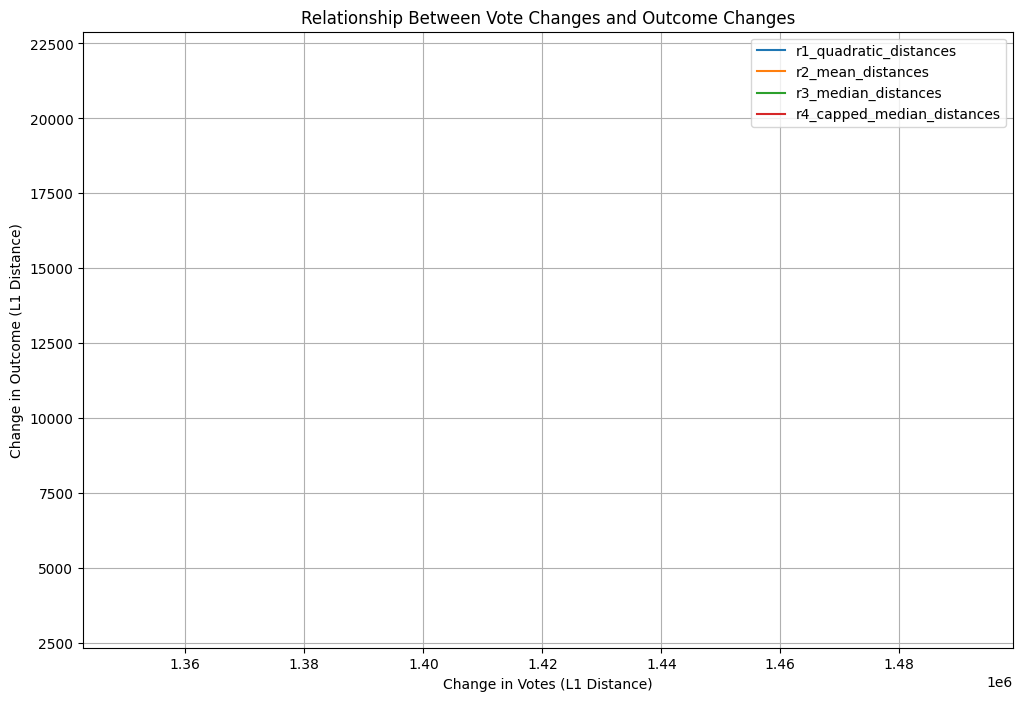

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_robustness_ordered(robustness_df):
    """Plot the relationship between vote changes and outcome changes after ordering by vote change."""
    # Replace 0 values with the column mean in the specified columns
    columns_to_replace = [
        #'majoritarian_moving_phantoms_distances', 
        'r1_quadratic_distances', 
        'r2_mean_distances', 
        'r3_median_distances',
        'r4_capped_median_distances'
    ]
   

    # Sort by changed_vote_l1_distances
    robustness_df = robustness_df.sort_values(by='changed_vote_l1_distances').reset_index(drop=True)

    # Plot each voting rule's outcome change against the changed vote L1 distance
    plt.figure(figsize=(12, 8))
    
    for method in columns_to_replace:
        plt.plot(robustness_df['changed_vote_l1_distances'], robustness_df[method], label=method)

    plt.xlabel('Change in Votes (L1 Distance)')
    plt.ylabel('Change in Outcome (L1 Distance)')
    plt.title('Relationship Between Vote Changes and Outcome Changes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming robustness_df is your DataFrame with the results
plot_robustness_ordered(robustness_results)


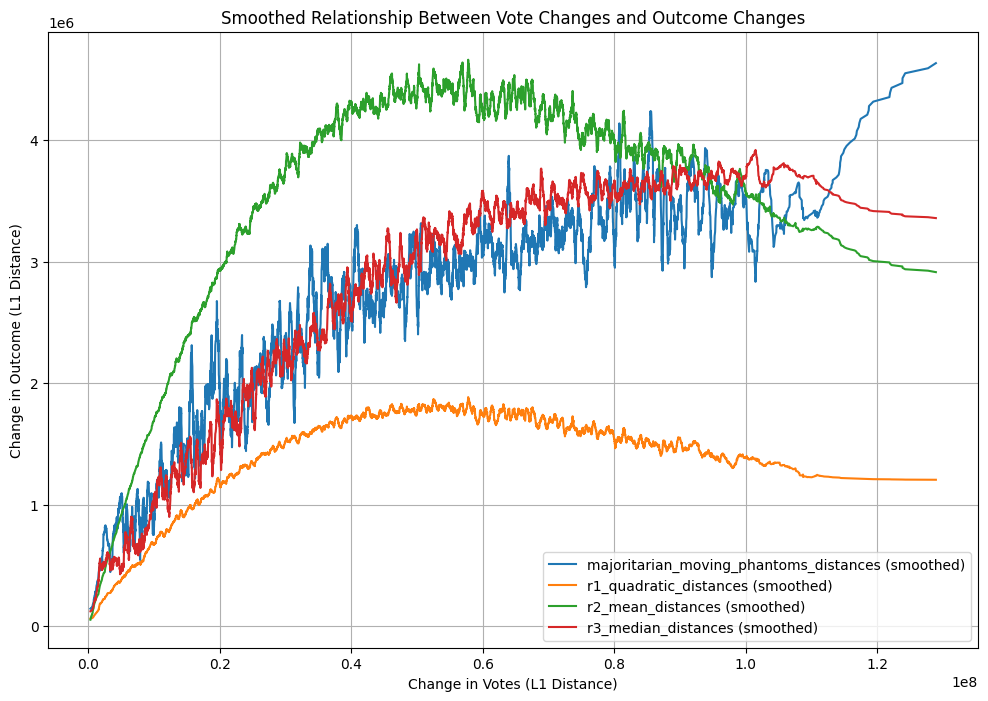

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

def plot_robustness_ordered(robustness_df, window_length=100, polyorder=2):
    """Plot the relationship between vote changes and outcome changes after applying Savitzky-Golay smoothing."""
    # Replace 0 values with the column mean in the specified columns
    columns_to_replace = [
        'majoritarian_moving_phantoms_distances', 
        'r1_quadratic_distances', 
        'r2_mean_distances', 
        'r3_median_distances'
    ]
   
    # Sort by changed_vote_l1_distances
    robustness_df = robustness_df.sort_values(by='changed_vote_l1_distances').reset_index(drop=True)

    # Apply smoothing to the voting rule columns using Savitzky-Golay filter
    smoothed_results = {}
    
    for method in columns_to_replace:
        smoothed_results[method] = savgol_filter(robustness_df[method], window_length=window_length, polyorder=polyorder)

    # Plot each voting rule's outcome change against the smoothed changed vote L1 distance
    plt.figure(figsize=(12, 8))
    
    for method in columns_to_replace:
        plt.plot(robustness_df['changed_vote_l1_distances'], smoothed_results[method], label=f"{method} (smoothed)")

    plt.xlabel('Change in Votes (L1 Distance)')
    plt.ylabel('Change in Outcome (L1 Distance)')
    plt.title('Smoothed Relationship Between Vote Changes and Outcome Changes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming robustness_df is your DataFrame with the results
plot_robustness_ordered(robustness_results)


# Evaluate Bribery Cost

The **bribery cost** metric evaluates how much effort is required to manipulate a voting system in order to increase the allocation to a specific project. The concept of bribery in this context refers to adding or reallocating votes in such a way that the funding for a particular project increases by a desired percentage. The **bribery cost** is the total amount of additional votes (tokens) required to achieve this manipulation.

In your `EvalMetrics` class, the **bribery cost** is implemented by simulating a series of small vote reallocations (bribery actions) until the desired increase in funding for the target project is achieved. The cost of each action is accumulated to give the total bribery cost.

### Implementation of the Bribery Cost Metric in the `EvalMetrics` Class

#### Key Steps in Implementing the Bribery Cost Metric:
1. **Simulate the Bribery Process**:
   - The voting matrix is manipulated by incrementally increasing the number of votes allocated to a specific project. The process continues until the funding for the project meets or exceeds the desired target.

2. **Calculate the Total Bribery Cost**:
   - Each incremental reallocation of votes represents a "bribery action," and the total number of additional votes is tracked. This value represents the **bribery cost**.

3. **Evaluate Bribery Across Multiple Rounds**:
   - The function evaluates bribery costs over multiple rounds for different voting rules, allowing for a comprehensive assessment of the system’s vulnerability to bribery.

### Step 1: Simulate the Bribery Process

The `simulate_bribery_generic` function simulates the bribery process, where additional votes are added to a target project until the desired increase in funding is achieved.

```python
def simulate_bribery_generic(self, voting_rule, target_project, desired_increase):
    """
    Generalized bribery simulation for any voting rule.
    
    Parameters:
    - voting_rule: The voting rule method (e.g., 'r1_quadratic', 'r2_mean', etc.)
    - target_project: The project that we are targeting for bribery.
    - desired_increase: The percentage increase we want in the target project's allocation.

    Returns:
    - bribery_cost: The total additional votes required (bribery cost).
    """
    num_voters, num_projects = self.model.voting_matrix.shape
    original_allocation = self.model.allocate_funds(voting_rule)
    original_funds = original_allocation[target_project]
    
    tolerance = 0.0001 * self.model.total_op_tokens
    target_funds = original_funds + desired_increase

    bribery_cost = 0
    new_voting_matrix = self.model.voting_matrix.copy()
    original_matrix = self.model.voting_matrix.copy()

    max_no_progress_iterations = 5
    no_progress_iterations = 0
    prev_funds = original_funds

    try:
        while True:
            # Temporarily assign the updated matrix to self.model.voting_matrix
            self.model.voting_matrix = new_voting_matrix
            
            # Recalculate the allocation with the updated voting matrix
            new_allocation = self.model.allocate_funds(voting_rule)
            new_funds = new_allocation[target_project]

            # Check if the new allocation meets or exceeds the target
            if new_funds >= target_funds or abs(new_funds - target_funds) < tolerance:
                print(f"Target met. Final Funds: {new_funds}, Bribery Cost: {bribery_cost}")
                break

            # Handle lack of progress (if adding votes does not change the allocation much)
            if abs(new_funds - prev_funds) < tolerance:
                no_progress_iterations += 1
                if no_progress_iterations >= max_no_progress_iterations:
                    # If no progress is made after several iterations, stop the process
                    bribery_cost = self.model.total_op_tokens
                    print(f"For project {target_project} and voting rule {voting_rule}, the bribery cost is infinite")
                    break
            else:
                no_progress_iterations = 0  # Reset if progress is made
            
            # Add a small, fixed amount of additional votes (say 1% of the original votes)
            additional_votes = 0.01 * np.sum(original_matrix[:, target_project])
            new_voting_matrix[:, target_project] += additional_votes

            prev_funds = new_funds
            
            # Accumulate the additional votes into the bribery cost
            bribery_cost += additional_votes

    finally:
        # Restore the original voting matrix
        self.model.voting_matrix = original_matrix

    return bribery_cost
```

#### Explanation:
- **Initial Setup**:
   - The function retrieves the original allocation for the target project using the specified voting rule. The target funding is calculated based on the original allocation plus the desired percentage increase.
   
- **Loop to Add Additional Votes**:
   - The bribery process works by iteratively adding small amounts of votes (1% of the original votes) to the target project. After each addition, the new allocation is recalculated.
   
- **Stopping Conditions**:
   - The loop continues until the new allocation for the target project meets or exceeds the desired funding target. If the allocation stops changing after several iterations, the process is halted, and the bribery cost is set to a large value, indicating that bribery is infeasible.

- **Track Bribery Cost**:
   - Each time additional votes are added, the total number of additional votes is accumulated. This value represents the **bribery cost**.

- **Return the Bribery Cost**:
   - The function returns the total number of votes (tokens) that had to be added to the target project to achieve the desired increase in funding.

### Step 2: Evaluate Bribery Across Multiple Rounds

The `evaluate_bribery` function runs multiple rounds of the bribery simulation for different voting rules and projects. It tracks the bribery cost for each voting rule and project.

```python
def evaluate_bribery(self, num_rounds=10, desired_increase_percentage=10):
    """
    Evaluate the bribery costs for increasing the allocation to a project by a desired percentage.
    """
    results = {'round': list(range(1, num_rounds + 1)), 'desired_increase': []}
    
    for voting_rule in self.model.voting_rules.keys():
        results[f'{voting_rule}_bribery_cost'] = []

    # Track the overall progress for the number of rounds
    with tqdm(total=num_rounds, desc="Bribery Evaluation Progress", unit="round") as round_progress_bar:
        for i in range(num_rounds):
            print(f"\n--- Round {i + 1}/{num_rounds} ---")
            self.model.step()  # Simulate the next round
            desired_increase_percentage_current_round = desired_increase_percentage
            results['desired_increase'].append(desired_increase_percentage_current_round)

            # For each voting rule, calculate the bribery cost for all projects
            for voting_rule in tqdm(self.model.voting_rules.keys(), desc=f"Round {i + 1}: Processing Voting Rules", leave=False, unit="rule"):
                original_allocation = self.model.allocate_funds(voting_rule)
                min_bribery_cost = float('inf')

                # Track progress for each project
                for project in range(self.model.num_projects):
                    original_funds = original_allocation[project]
                    desired_increase = original_funds * desired_increase_percentage_current_round

                    # Simulate bribery for the current project
                    bribery_cost = self.simulate_bribery_generic(voting_rule, project, desired_increase)

                    # Update the minimum bribery cost for the current voting rule
                    if bribery_cost < min_bribery_cost:
                        min_bribery_cost = bribery_cost

                # Append the bribery cost for the current voting rule
                results[f'{voting_rule}_bribery_cost'].append(min_bribery_cost)

            # Update the round progress bar
            round_progress_bar.update(1)

    # Convert results to a DataFrame
    final_results = pd.DataFrame(results)
    print("\nAll rounds completed. Final results:\n", final_results)
    return final_results
```

#### Explanation:
- **Simulate Multiple Rounds**:
   - The function runs multiple rounds of the bribery simulation. In each round, the voting matrix is updated using `self.model.step()`, and the bribery cost is calculated for each voting rule and project.

- **Track the Minimum Bribery Cost**:
   - For each voting rule, the bribery cost is calculated for every project. The minimum bribery cost across all projects is recorded for the given voting rule and round.

- **Store Results**:
   - The results (bribery costs) are stored in a dictionary and later converted to a DataFrame for easy analysis and visualization.

- **Return the Final Results**:
   - After all rounds are completed, the function returns the bribery costs for each voting rule and round as a DataFrame.

### Example Walkthrough:

1. **Original Allocation**:
   - Suppose there are 3 projects, and the original allocation of tokens is:
     ```
     Project 1: 100 tokens
     Project 2: 200 tokens
     Project 3: 50 tokens
     ```

2. **Target Funding Increase**:
   - We want to increase the funding for Project 1 by 10%, so the target funding becomes:
     \[
     100 \times (1 + 0.1) = 110 \text{ tokens}
     \]

3. **Simulating Bribery**:
   - Additional votes are added increment

ally to Project 1. If adding 10 additional votes is enough to raise Project 1’s funding to 110 tokens, the bribery cost is `10`.

4. **Repeat for Multiple Voting Rules**:
   - The process is repeated for each voting rule to determine how resistant each rule is to bribery.

### Summary:
- The **bribery cost** metric evaluates how many additional votes (tokens) need to be allocated to a target project in order to increase its funding by a specified percentage.
- The **simulate_bribery_generic** function iteratively adds votes to the target project until the desired increase is achieved. The total number of additional votes represents the **bribery cost**.
- The **evaluate_bribery** function runs multiple rounds of the simulation and calculates the bribery cost for each voting rule and project, returning the results in a DataFrame for further analysis.
- This metric helps assess the vulnerability of the voting system to manipulation, indicating how much effort is required to shift the outcome in favor of a particular project through bribery.

In [ ]:
#bribery_results = eval_metrics.evaluate_bribery(num_rounds)
bribery_constant_desired_increase_results = eval_metrics.evaluate_bribery(num_rounds,1)
bribery_constant_desired_increase_results.to_csv(os.path.join(output_dir, 'bribery_constant_desired_increase_results.csv'), index=False)
print("Bribery Cost Results:")
bribery_constant_desired_increase_results.head(100)

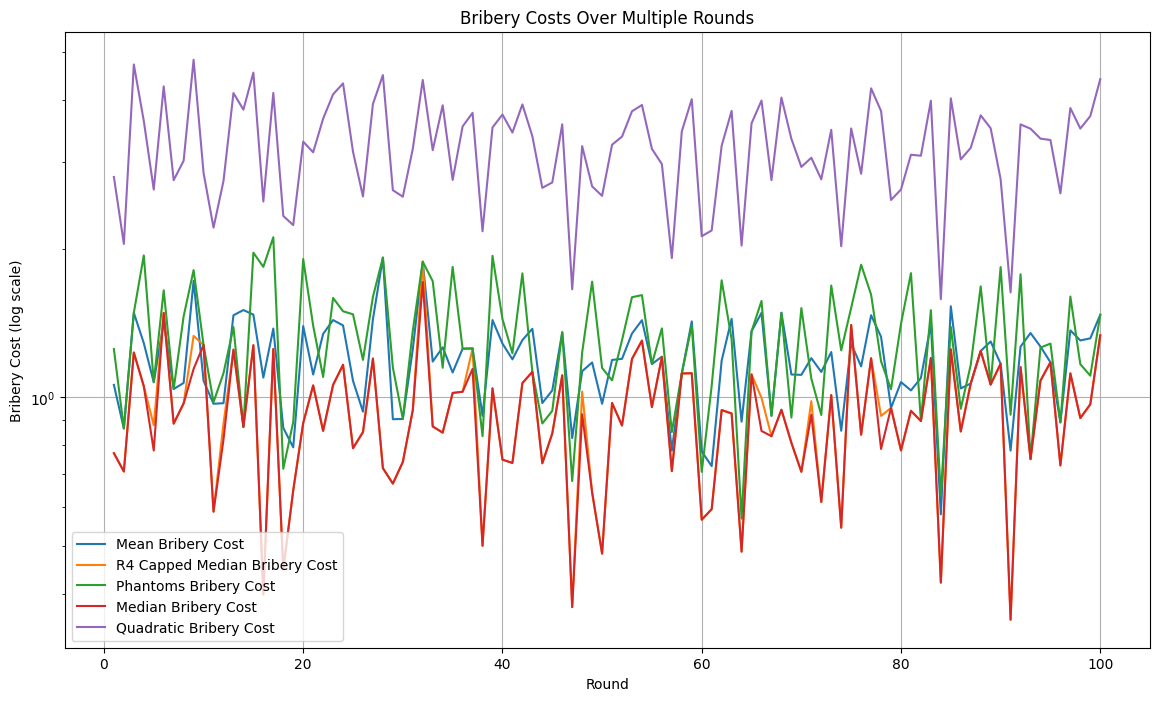

In [ ]:
import matplotlib.pyplot as plt

# Plot the results with a logarithmic y-axis
def plot_bribery_costs(df):
    plt.figure(figsize=(14, 8))

    # Plot mean bribery cost
    plt.plot(df['round'], df['r2_mean_bribery_cost'], label='Mean Bribery Cost')

    plt.plot(df['round'], df['r4_capped_median_bribery_cost'], label='R4 Capped Median Bribery Cost')
    plt.plot(df['round'], df['majoritarian_moving_phantoms_bribery_cost'], label='Phantoms Bribery Cost')

    # Plot median bribery cost
    plt.plot(df['round'], df['r3_median_bribery_cost'], label='Median Bribery Cost')

    # Plot quadratic bribery cost
    plt.plot(df['round'], df['r1_quadratic_bribery_cost'], label='Quadratic Bribery Cost')

    plt.xlabel('Round')
    plt.ylabel('Bribery Cost (log scale)')
    plt.yscale('log')
    plt.title('Bribery Costs Over Multiple Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the bribery costs
plot_bribery_costs(bribery_constant_desired_increase_results)

In [ ]:
summary_stats = bribery_constant_desired_increase_results[['r1_quadratic_bribery_cost', 'r2_mean_bribery_cost', 'r3_median_bribery_cost',"majoritarian_moving_phantoms_bribery_cost",'r4_capped_median_bribery_cost']].describe()
print(summary_stats)

       r1_quadratic_bribery_cost  r2_mean_bribery_cost  \
count                 100.000000            100.000000   
mean                    3.239740              1.193338   
std                     0.729320              0.240679   
min                     1.580524              0.579525   
25%                     2.737229              1.041685   
50%                     3.270137              1.192003   
75%                     3.795607              1.361957   
max                     4.825523              1.918288   

       r3_median_bribery_cost  majoritarian_moving_phantoms_bribery_cost  \
count              100.000000                                 100.000000   
mean                 0.926907                                   1.314827   
std                  0.259908                                   0.358477   
min                  0.354564                                   0.568134   
25%                  0.749265                                   1.059962   
50%                  

# VEV

The **Voter Extractable Value (VEV)** metric measures how much a single voter can influence the allocation outcome by allocating a large portion of their voting power (e.g., 90-99%) to a specific project. The idea is to evaluate how sensitive the voting system is to extreme preferences expressed by a single voter. The **VEV** metric provides insights into the potential for a voter to skew the outcome significantly toward a project they favor, quantifying the degree to which they can "extract" value for that project.

### VEV Definition in the Simulation

For each voter and project, the VEV metric calculates the maximum **L1 distance** (or skewness) between the original allocation and a new allocation in which the voter has allocated a large percentage (90-99%) of their tokens to a specific project. The higher the L1 distance, the more the voter can shift the final outcome by favoring a particular project. This metric helps assess the vulnerability of the system to extreme voter behavior.

### Implementation of the VEV Metric in the `EvalMetrics` Class

#### Key Steps in Implementing the VEV Metric:

1. **Modify a Voter’s Vote**:
   - The voter reallocates a large percentage of their tokens (90-99%) to one specific project and distributes the remaining tokens across other projects.
   
2. **Calculate the L1 Distance**:
   - The **L1 distance** is computed between the original allocation and the new allocation (after the modified vote). This distance represents the degree of skewness the voter introduced by heavily favoring a particular project.

3. **Evaluate VEV Across Multiple Rounds**:
   - The function evaluates VEV over multiple rounds, calculating the maximum L1 distance for each voting rule and tracking the project that is most influenced by the modified vote.

### Step 1: Modify a Voter’s Vote

The `modify_vote` function simulates a voter allocating a high percentage (e.g., 90-99%) of their tokens to one project and distributing the remaining tokens equally across all other projects.

```python
def modify_vote(self, voter, project, r):
    """
    Modify the vote of voter `i` by allocating r% of their funds to project `k`.
    The remainder is distributed equally across the other projects.
    
    Parameters:
    - voter: Index of the voter whose vote will be modified.
    - project: Index of the project where the majority of the funds will go.
    - r: The percentage of total funds allocated to the selected project.

    Returns:
    - modified_vote: The new vote profile for the voter with modified allocations.
    """
    total_funds = self.model.total_op_tokens
    num_projects = self.model.num_projects

    # Allocate r% of funds to the selected project
    modified_vote = np.zeros(num_projects)
    modified_vote[project] = r * total_funds

    # Distribute the remaining (1 - r)% equally across the other projects
    remaining_funds = (1 - r) * total_funds
    for other_project in range(num_projects):
        if other_project != project:
            modified_vote[other_project] = remaining_funds / (num_projects - 1)

    return modified_vote
```

#### Explanation:
- **Allocate r% to the Target Project**:
   - The function takes a percentage `r` (e.g., 90-99%) and allocates that percentage of the voter’s total tokens to a specific project.
   
- **Distribute Remaining Tokens**:
   - The remaining tokens (1-r) are equally distributed across the other projects, ensuring that the total number of tokens remains the same.

### Step 2: Calculate the L1 Distance

The L1 distance between the original allocation and the new allocation (after the voter modifies their vote) represents the magnitude of the change caused by this extreme voting behavior.

```python
def calculate_l1_distance(self, x, x_prime):
    """Calculate the L1 distance (Manhattan distance) between two vectors."""
    return np.sum(np.abs(x - x_prime))
```

#### Explanation:
- **L1 Distance**:
   - The L1 distance is the sum of the absolute differences between two vectors. In this case, it is used to quantify how much the modified vote shifts the allocation compared to the original outcome.

### Step 3: Evaluate VEV Across Multiple Rounds

The `evaluate_vev` function evaluates the VEV across multiple rounds by simulating the process for different voting rules and projects. It tracks the maximum L1 distance (i.e., the maximum skewness) introduced by each voter-project pair.

```python
def evaluate_vev(self, num_rounds=100, r_min=90, r_max=99):
    """
    Evaluate the Voter Extractable Value (VEV) for a given voting rule.

    Parameters:
    - num_rounds: Number of instances to compute VEV across different vote profiles.
    - r_min: Minimum percentage allocation to the specific project (default: 90%).
    - r_max: Maximum percentage allocation to the specific project (default: 99%).

    Returns:
    - VEV_results: DataFrame containing the VEV for each instance and voting rule.
    """
    results = {
        'round': [],        # Store round info for each instance and rule
        'voting_rule': [],  # Store the voting rule for each instance
        'max_vev': [],      # Store the maximum VEV for each instance
        'project_max_vev': [],      # Project with maximum VEV
        'project_max_vev_percentage': [],  # Percentage change of max VEV project
        'project_max_original_allocation': [],  # Original allocation for max VEV project
        'project_max_new_allocation': [],  # New allocation for max VEV project
        'project_max_allocation_percentage': []  # Percentage allocation of the max VEV project
    }
    r_values = np.linspace(r_min / 100, r_max / 100, 5)
    
    for instance in range(1, num_rounds + 1):  # Loop through rounds
        self.model.step()  # Simulate a new vote profile

        for voting_rule in self.model.voting_rules.keys():
            max_vev = float('-inf')  # Track the maximum VEV for this rule
            project_max_vev = float('-inf')
            project_max_new_allocation = float('-inf')
            project_max_original_allocation  = float('-inf')

            # Get the original allocation using the voting rule
            original_allocation = self.model.allocate_funds(voting_rule)

            # For each voter and each project, modify the vote and evaluate VEV
            for voter in range(self.model.num_voters):
                for project in range(self.model.num_projects):
                    project_original_allocation = original_allocation[project]

                    # Iterate through r values from r_min to r_max (e.g., 90% to 99%)
                    for r in r_values:
                        # Modify the voter's vote to allocate r% to the target project
                        modified_vote_matrix = self.model.voting_matrix.copy()
                        modified_vote_matrix[voter] = self.modify_vote(voter, project, r)

                        # Apply the modified vote profile to get a new allocation
                        new_allocation = self.model.allocate_funds(voting_rule, modified_vote_matrix)
                        project_new_allocation = new_allocation[project]

                        # Calculate the L1 distance (VEV) between original and new allocation
                        l1_distance = np.sum(np.abs(original_allocation - new_allocation))
                        project_allocation_difference = project_new_allocation - project_original_allocation

                        # Track the maximum VEV
                        if l1_distance > max_vev:
                            max_vev = l1_distance
                        if project_allocation_difference > project_max_vev:
                            project_max_vev = project_allocation_difference
                            project_max_new_allocation = project_new_allocation
                            project_max_original_allocation = project_original_allocation

            # Log the maximum VEV for this instance and voting rule
            results['round'].append(instance)  # Add round number dynamically
            results['voting_rule'].append(voting_rule)  # Add the voting rule
            results['max_vev'].append(max_vev)  # Add the maximum VEV
            results['project_max_vev'].append(project_max_vev)
            results['project_max_vev_percentage'].append(project_max_vev / self.model.total_op_tokens)
            results['project_max_original_allocation'].append(project_max_original_allocation)
            results['project_max_new_allocation'].append(project_max_new_allocation)
            results['project_max_allocation_percentage'].append(project_max_new_allocation / self.model.total_op_tokens)

    # Create a DataFrame to store results
    VEV_results = pd.DataFrame(results)
    return VEV_results
```

#### Explanation:
- **Loop Over Multiple Rounds**:
   - The function loops through multiple rounds of the simulation, generating a new vote profile in each round using `self.model.step()`.
   
- **Evaluate VEV for Each Voting Rule**:
   - For each voting rule, the function modifies each voter’s vote (one by one) and calculates the resulting new allocation.
   
- **Calculate L1 Distance**:
   - The L1 distance between the original allocation and the new allocation is calculated to measure the impact of the modified vote on the system. This L1 distance represents the **VEV**.
   
- **Track Maximum VEV**:
   - The function keeps track of the maximum VEV observed for each voter-project combination and logs the corresponding project, new allocation, and percentage change.
   
- **Return Results**:


   - The results are returned as a DataFrame, showing the maximum VEV for each voting rule across multiple rounds.

### Example Walkthrough:

1. **Original Allocation**:
   - Suppose there are 3 projects, and the original allocation of tokens is:
     ```
     Project 1: 100 tokens
     Project 2: 200 tokens
     Project 3: 50 tokens
     ```

2. **Modify a Voter’s Vote**:
   - A voter reallocates 95% of their tokens to Project 1. If the original vote was:
     ```
     Voter's original vote: [30, 40, 30]
     ```
     The modified vote becomes:
     ```
     Voter's modified vote: [95, 2.5, 2.5]
     ```

3. **Original and New Outcomes**:
   - Suppose the voting rule originally produces the following allocation:
     ```
     Original Outcome: [100, 200, 50]
     ```
   - After modifying the voter’s vote, the new allocation might be:
     ```
     New Outcome: [130, 170, 50]
     ```

4. **Calculate L1 Distance**:
   - The L1 distance between the original and new outcome is:
     \[
     |100-130| + |200-170| + |50-50| = 30 + 30 + 0 = 60
     \]
   - This distance indicates the magnitude of influence the voter exerted by skewing their vote toward Project 1.

5. **Repeat for Multiple Voters and Projects**:
   - The process is repeated for each voter and project, and the maximum L1 distance (VEV) is tracked.

### Summary:
- The **Voter Extractable Value (VEV)** metric measures how much a single voter can influence the outcome of the voting system by allocating a large percentage of their tokens to one project.
- The **modify_vote** function simulates extreme voting behavior, and the **L1 distance** between the original and new allocation quantifies the magnitude of influence.
- The **evaluate_vev** function runs multiple rounds of simulations, modifying votes for each voter and project, and records the maximum VEV for each voting rule.
- This metric helps assess the vulnerability of the voting system to extreme behavior and quantifies the potential for a voter to skew the allocation in favor of a particular project.

In [ ]:
vev_results = eval_metrics.evaluate_vev(num_rounds)
vev_results['project_max_vev']=vev_results['project_max_vev']/total_op_tokens
vev_results.to_csv(os.path.join(output_dir, 'vev_results.csv'), index=False)

vev_results.head(100)

,round,voting_rule,max_vev,project_max_vev
0,1,majoritarian_moving_phantoms,14.880735,1.710698
1,1,r1_quadratic,8.582477,3.257384
2,1,r2_mean,42.415826,21.207913
3,1,r3_median,17.342214,1.411171
4,1,r4_capped_median,18.207881,1.389362
5,2,majoritarian_moving_phantoms,17.932586,2.513352
6,2,r1_quadratic,8.526092,3.217795
7,2,r2_mean,42.414341,21.207171
8,2,r3_median,16.539237,1.630731
9,2,r4_capped_median,16.204765,1.669750


In [ ]:
vev_results['project_max_vev']=vev_results['project_max_vev']/total_op_tokens
vev_results.to_csv(os.path.join(output_dir, 'vev_results_norm.csv'), index=False)

vev_results.head(100)

,round,voting_rule,max_vev,project_max_vev
0,1,majoritarian_moving_phantoms,14.880735,0.005702
1,1,r1_quadratic,8.582477,0.010858
2,1,r2_mean,42.415826,0.070693
3,1,r3_median,17.342214,0.004704
4,1,r4_capped_median,18.207881,0.004631
5,2,majoritarian_moving_phantoms,17.932586,0.008378
6,2,r1_quadratic,8.526092,0.010726
7,2,r2_mean,42.414341,0.070691
8,2,r3_median,16.539237,0.005436
9,2,r4_capped_median,16.204765,0.005566
